# STOCK MARKET PREDICTION WITH LSTM MODEL

## 1. INSTALATION AND IMPRORTING LIBRARIES

In [ ]:
#pip install tensorflow

In [ ]:
#pip install keras


In [ ]:
#pip install yahoo_fin


In [2]:
import tensorflow as tf

import numpy as np  
import matplotlib.pyplot as plt  
import datetime as dt
import pandas as pd  
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential  
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import Dropout 
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from math import sqrt
import tensorflow as tf 
import matplotlib as mpl
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from yahoo_fin.stock_info import *
import seaborn as sns

%matplotlib inline

## 2. 'IBM' STOCK DATA FROM YAHOO FINANCIAL API

In [3]:
ibm_data = monthly_data = get_data("IBM",start_date = '01/01/1995', interval = "1mo")
# Reset the index
ibm_data = ibm_data.reset_index()

# Rename the "index" column to "TIME"
ibm_data = ibm_data.rename(columns={"index": "DATE"})

ibm_data['DATE'] = pd.to_datetime(ibm_data['DATE'])
ibm_data['DATE'] = ibm_data['DATE'].dt.strftime('%Y-%m')
ibm_data = ibm_data.drop(['ticker'], axis=1)
ibm_data = ibm_data[['DATE', 'close']]

ibm_data = ibm_data.drop_duplicates()  # This removes duplicate rows
ibm_data = ibm_data[~ibm_data.index.duplicated(keep='first')]  # This removes duplicate index values if any


ibm_data.set_index('DATE', inplace=True)
ibm_data.index = pd.to_datetime(ibm_data.index)
ibm_data.head()

,close
DATE,
1995-01-01,17.238289
1995-02-01,17.985182
1995-03-01,19.628345
1995-04-01,22.615917
1995-05-01,22.227533


In [4]:
# Code to fill missing values with the mean value of the column

# Check if there are any missing values in the 'close' column
missing_values = ibm_data['close'].isna().sum()
print(f"Number of missing values in 'close': {missing_values}")




Number of missing values in 'close': 0


In [5]:
ibm_data.head()

,close
DATE,
1995-01-01,17.238289
1995-02-01,17.985182
1995-03-01,19.628345
1995-04-01,22.615917
1995-05-01,22.227533


In [6]:


# Assuming the 'data' DataFrame contains the stock price data with a column named 'close'
# Function to perform the Dickey-Fuller test for stationarity
def test_stationarity(timeseries):
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Perform stationarity test on the 'close' column of the dataset
test_stationarity(ibm_data['close'])


Results of Dickey-Fuller Test:
Test Statistic                  -2.017504
p-value                          0.278951
#Lags Used                       1.000000
Number of Observations Used    347.000000
Critical Value (1%)             -3.449337
Critical Value (5%)             -2.869906
Critical Value (10%)            -2.571227
dtype: float64


In [7]:
# Applying first differencing to the 'close' column to make the data stationary
ibm_data['close_diff'] = ibm_data['close'].diff()

# Remove any NaN values created by differencing
data_diff = ibm_data.dropna()
# Re-run the Dickey-Fuller test on the differenced data
test_stationarity(data_diff['close_diff'])


Results of Dickey-Fuller Test:
Test Statistic                 -20.363115
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    347.000000
Critical Value (1%)             -3.449337
Critical Value (5%)             -2.869906
Critical Value (10%)            -2.571227
dtype: float64


In [8]:
# Filling the NaN values in 'close_diff' with the mean value of the differenced data

# Calculate the mean of the differenced data, excluding the NaN value
mean_diff = ibm_data['close_diff'].mean()

# Fill the NaN values in 'close_diff' with this mean value
ibm_data['close_diff'].fillna(mean_diff, inplace=True)




ibm_data


,close,close_diff
DATE,,
1995-01-01,17.238289,0.443223
1995-02-01,17.985182,0.746893
1995-03-01,19.628345,1.643164
1995-04-01,22.615917,2.987572
1995-05-01,22.227533,-0.388384
...,...,...
2023-09-01,140.300003,-6.529999
2023-10-01,144.639999,4.339996
2023-11-01,158.559998,13.919998


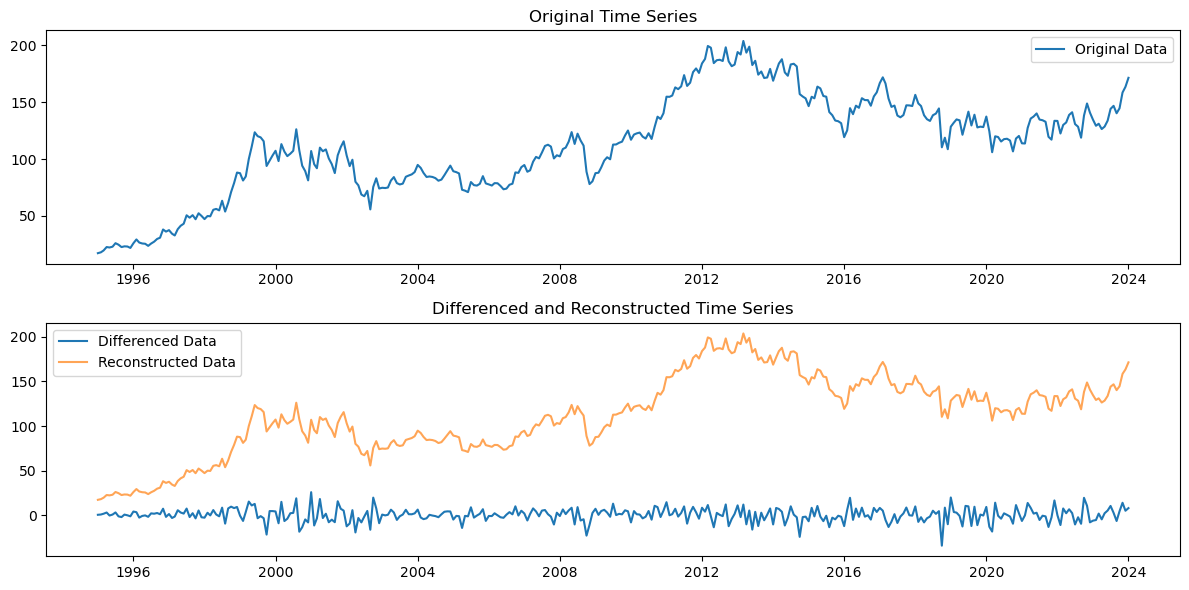

In [9]:

original_data =ibm_data['close']
differenced_data =ibm_data['close_diff']
reconstructed_data =ibm_data['close']
# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(original_data, label='Original Data')
plt.title('Original Time Series')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(differenced_data, label='Differenced Data')
plt.plot(reconstructed_data, label='Reconstructed Data', alpha=0.7)
plt.title('Differenced and Reconstructed Time Series')
plt.legend()

plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

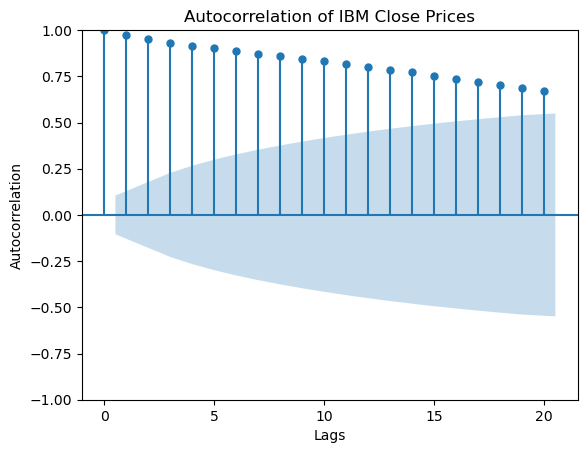

In [10]:

# Plotting the Autocorrelation for 'close_diff'
plt.figure(figsize=(12, 6))
plot_acf(ibm_data['close'], lags=20)
plt.title('Autocorrelation of IBM Close Prices' )
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

<Figure size 1200x600 with 0 Axes>

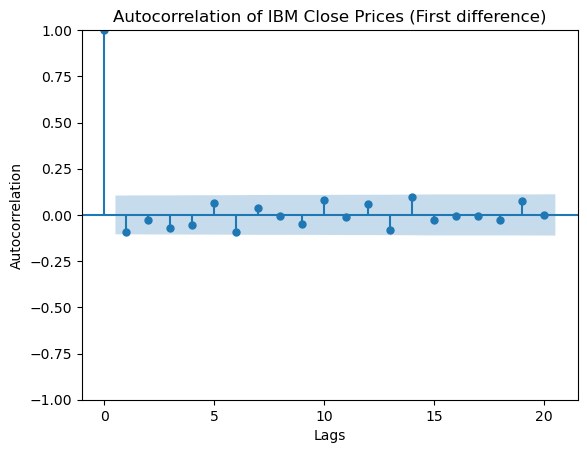

In [11]:

# Plotting the Autocorrelation for 'close_diff'
plt.figure(figsize=(12, 6))
plot_acf(ibm_data['close_diff'], lags=20)
plt.title('Autocorrelation of IBM Close Prices (First difference)' )
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

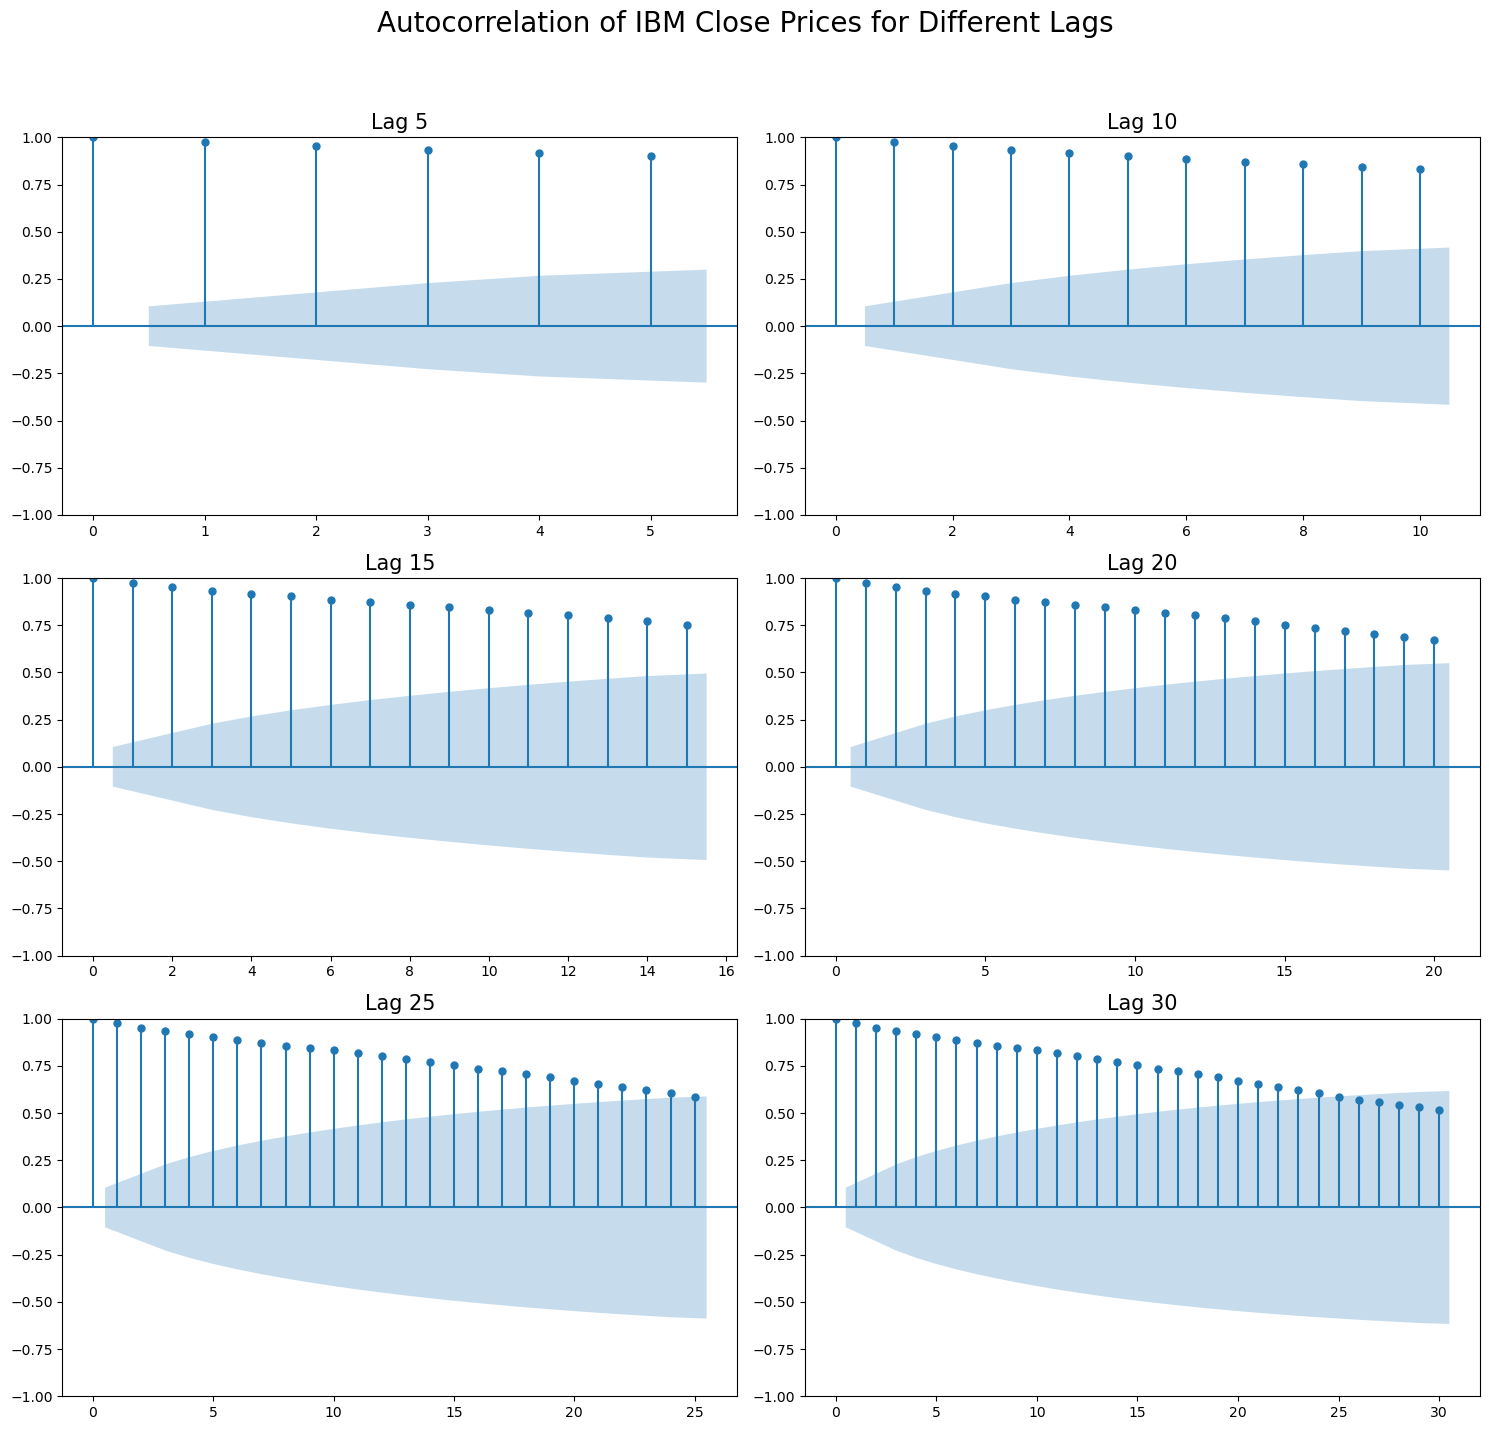

In [12]:

# Assuming ibm_data is already loaded and contains 'close' column with IBM stock prices
# Define the number of lags you want to plot
lags_to_plot = [5, 10, 15, 20, 25, 30]  # Ensure this list has the same number of elements as subplots you want to create

# Determine the number of rows and columns based on the length of lags_to_plot
num_plots = len(lags_to_plot)
num_rows = num_plots // 2 + num_plots % 2
num_cols = 2

# Create a grid of subplots with a specified figure size
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
fig.suptitle('Autocorrelation of IBM Close Prices for Different Lags', fontsize=20)

# Loop over the lags_to_plot list and create autocorrelation plots
for i, lag in enumerate(lags_to_plot):
    row, col = i // num_cols, i % num_cols
    plot_acf(ibm_data['close'], lags=lag, ax=ax[row, col], alpha=0.05)
    ax[row, col].set_title(f'Lag {lag}', fontsize=15)

# Adjust layout to prevent overlapping plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()


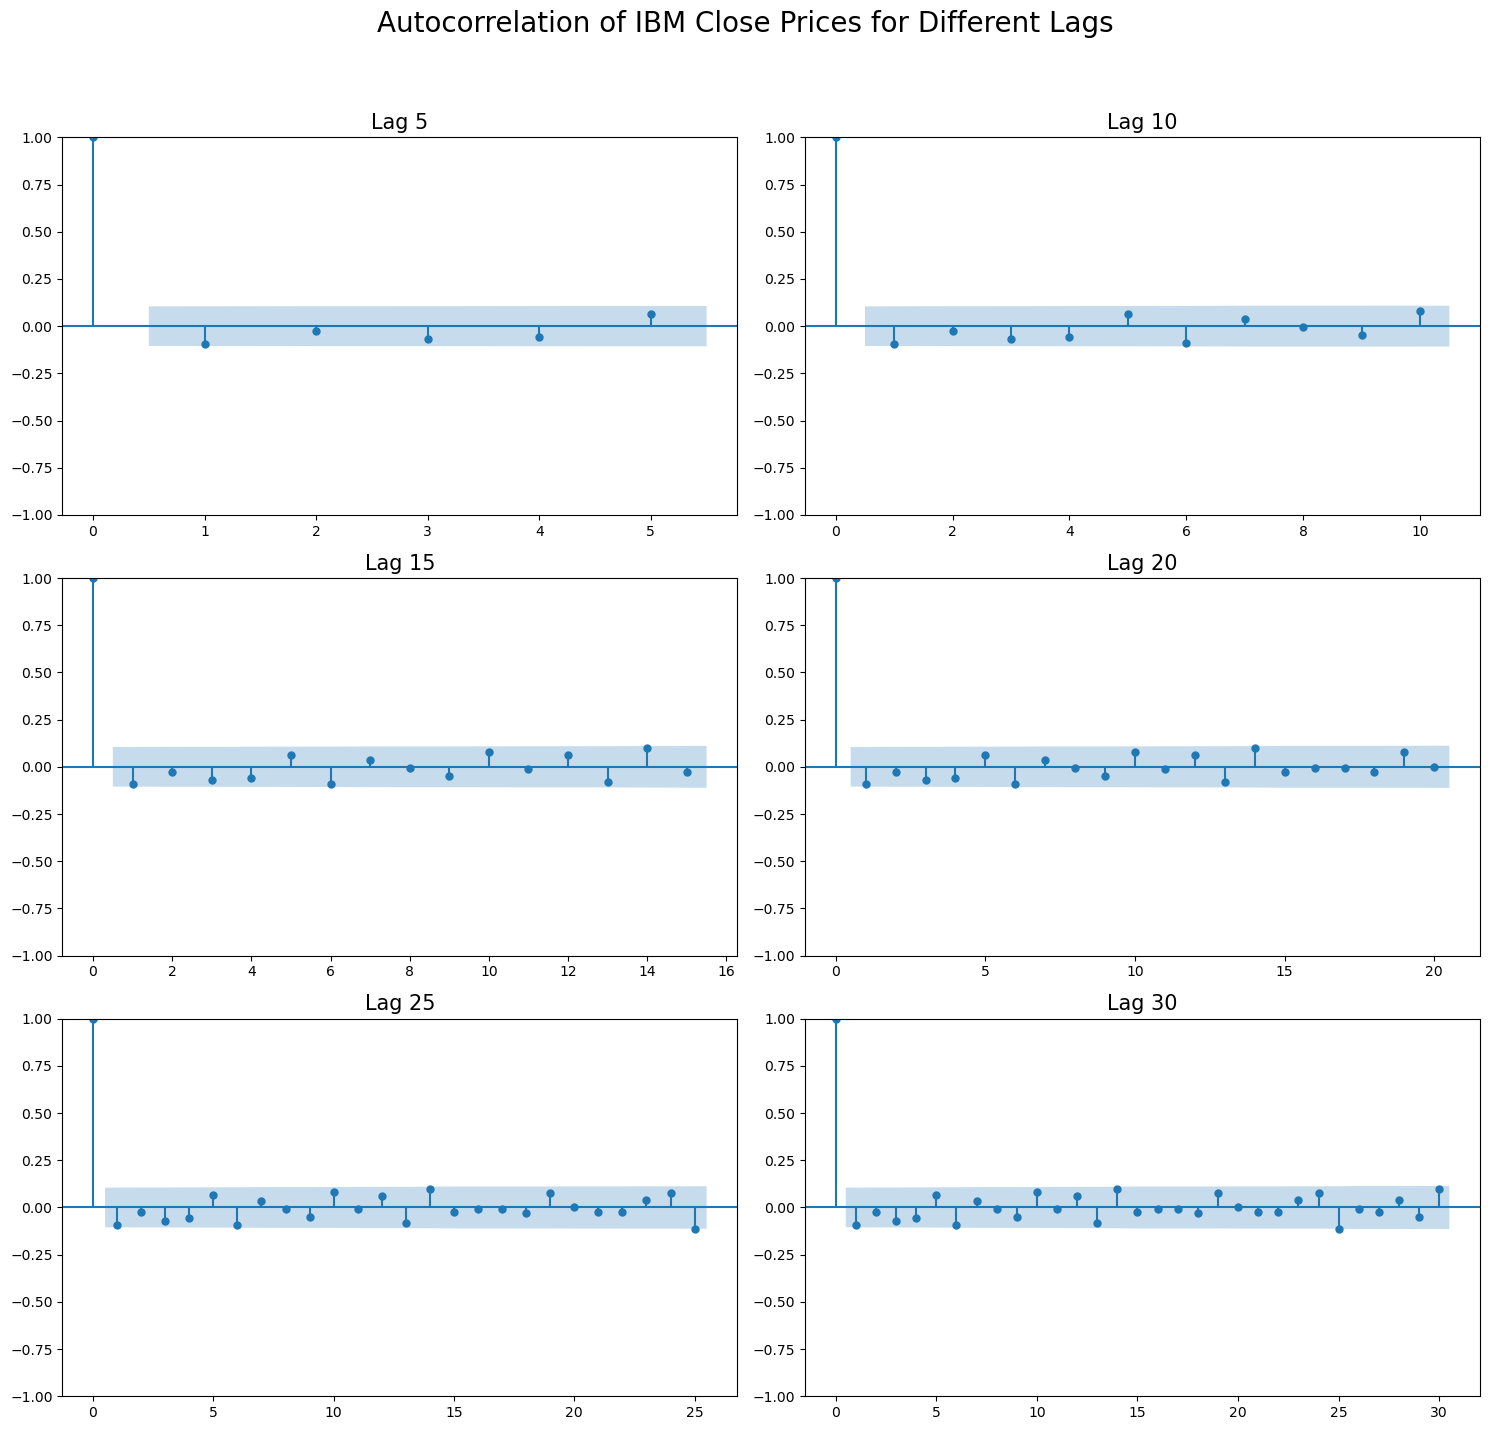

In [13]:

# Assuming ibm_data is already loaded and contains 'close' column with IBM stock prices
# Define the number of lags you want to plot
lags_to_plot = [5, 10, 15, 20, 25, 30]  # Ensure this list has the same number of elements as subplots you want to create

# Determine the number of rows and columns based on the length of lags_to_plot
num_plots = len(lags_to_plot)
num_rows = num_plots // 2 + num_plots % 2
num_cols = 2

# Create a grid of subplots with a specified figure size
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
fig.suptitle('Autocorrelation of IBM Close Prices for Different Lags', fontsize=20)

# Loop over the lags_to_plot list and create autocorrelation plots
for i, lag in enumerate(lags_to_plot):
    row, col = i // num_cols, i % num_cols
    plot_acf(ibm_data['close_diff'], lags=lag, ax=ax[row, col], alpha=0.05)
    ax[row, col].set_title(f'Lag {lag}', fontsize=15)

# Adjust layout to prevent overlapping plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()


## 5. SMA PREDICTION

C:\Users\DeLL\AppData\Local\Temp\ipykernel_1424\3265027757.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['sma'] = train_data['close'].rolling(window=window_size).mean()
C:\Users\DeLL\AppData\Local\Temp\ipykernel_1424\3265027757.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['sma'] = test_data['close'].rolling(window=window_size).mean()


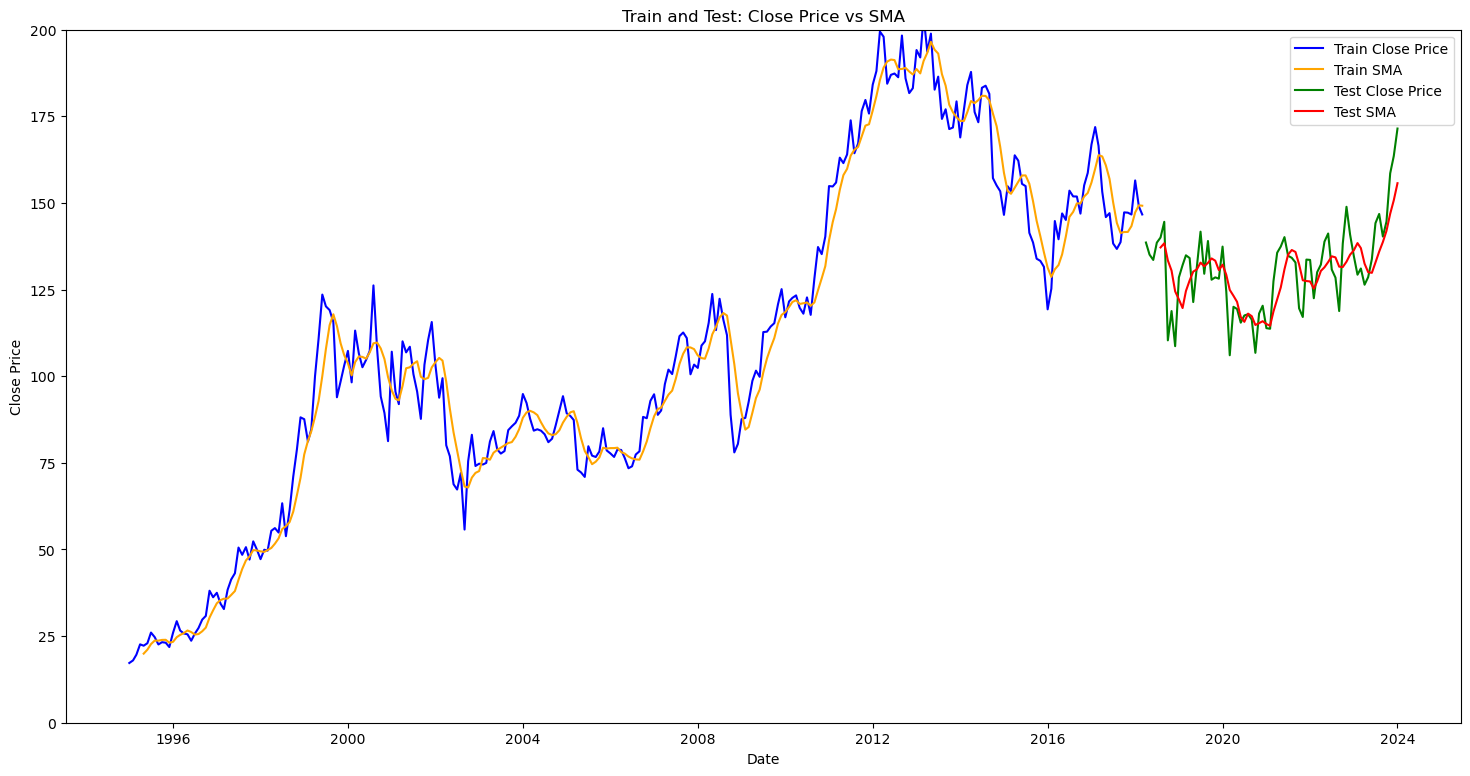

MSE error for SMA on Test Data: 69.84106


In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming ibm_data is already loaded with 'close' prices
# ibm_data = pd.read_csv('path_to_your_ibm_data.csv')

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the close prices
ibm_data_scaled = scaler.fit_transform(ibm_data['close'].values.reshape(-1, 1))

# Inverse scale the data to get the original prices back
ibm_data_unscaled = scaler.inverse_transform(ibm_data_scaled)

# Convert the unscaled data back to a DataFrame for convenience
ibm_data_unscaled_df = pd.DataFrame(ibm_data_unscaled, index=ibm_data.index, columns=['close'])

# Define the window size for SMA and the proportion for training data
window_size = 5  # Adjust this window size as needed
train_proportion = 0.8

# Calculate the index to split the data
split_index = int(len(ibm_data_scaled) * train_proportion)

# Split the data into training and testing sets
train_data = ibm_data_unscaled_df.iloc[:split_index]
test_data = ibm_data_unscaled_df.iloc[split_index:]

# Calculate SMA for the train data
train_data['sma'] = train_data['close'].rolling(window=window_size).mean()

# Apply SMA to the test data
test_data['sma'] = test_data['close'].rolling(window=window_size).mean()

# Plotting the SMA predictions against the original close prices
plt.figure(figsize=(18, 9))
plt.plot(train_data.index, train_data['close'], color='blue', label='Train Close Price')
plt.plot(train_data.index, train_data['sma'], color='orange', label='Train SMA')
plt.plot(test_data.index, test_data['close'], color='green', label='Test Close Price')
plt.plot(test_data.index, test_data['sma'], color='red', label='Test SMA')
plt.title('Train and Test: Close Price vs SMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.ylim(0, 200)  # Set y-axis limits from 0 to 200
plt.legend()
plt.show()

# Align the 'close' column to the length of the SMA-aligned data
test_data_aligned = test_data.dropna(subset=['sma'])

# Ensure both arrays have the same length now
assert len(test_data_aligned['sma']) == len(test_data_aligned['close']), "Lengths are not equal after dropping NaNs"

# Now you can calculate the MSE with the aligned data
mse_error_sma = mean_squared_error(test_data_aligned['close'], test_data_aligned['sma'])
print('MSE error for SMA on Test Data: {:.5f}'.format(mse_error_sma))


In [203]:
len(test_scaled)

128

## 6. EMA MODEL PREDICTION

C:\Users\DeLL\AppData\Local\Temp\ipykernel_1424\1934862544.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['ema'] = train_data['close'].ewm(span=span, adjust=False).mean()
C:\Users\DeLL\AppData\Local\Temp\ipykernel_1424\1934862544.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ema'] = test_data['close'].ewm(span=span, adjust=False).mean()


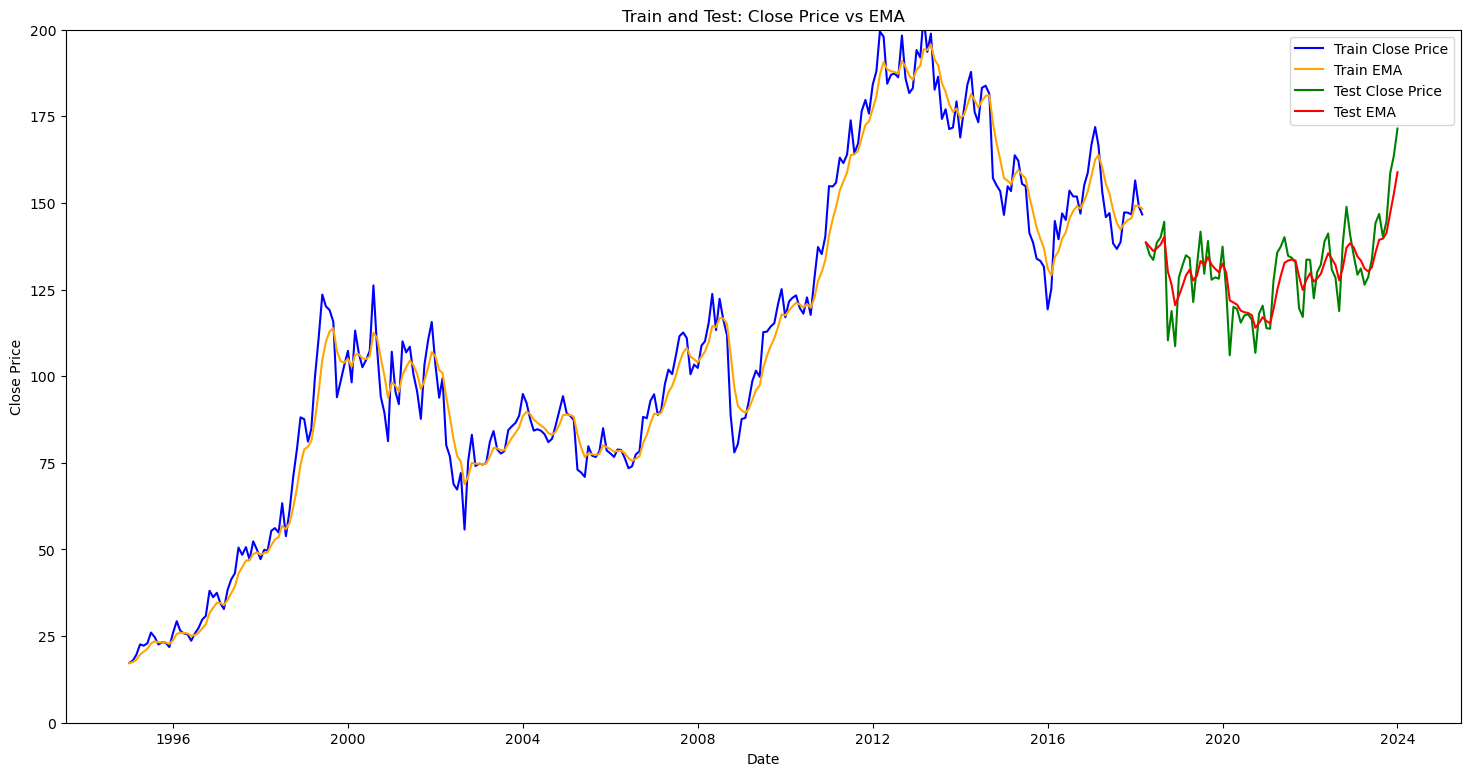

MSE error for EMA on Test Data: 40.60396


In [23]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming ibm_data is already loaded with 'close' prices
# ibm_data = pd.read_csv('path_to_your_ibm_data.csv')

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the close prices
ibm_data_scaled = scaler.fit_transform(ibm_data['close'].values.reshape(-1, 1))

# Inverse scale the data to get the original prices back
ibm_data_unscaled = scaler.inverse_transform(ibm_data_scaled)

# Convert the unscaled data back to a DataFrame for convenience
ibm_data_unscaled_df = pd.DataFrame(ibm_data_unscaled, index=ibm_data.index, columns=['close'])

# Define the proportion for training data
train_proportion = 0.8

# Calculate the index to split the data
split_index = int(len(ibm_data_scaled) * train_proportion)

# Split the data into training and testing sets
train_data = ibm_data_unscaled_df.iloc[:split_index]
test_data = ibm_data_unscaled_df.iloc[split_index:]

# Define the span for EMA calculation
span = 5  # This is similar to the 'window' parameter in SMA

# Calculate EMA for the train data
train_data['ema'] = train_data['close'].ewm(span=span, adjust=False).mean()

# Apply EMA to the test data
test_data['ema'] = test_data['close'].ewm(span=span, adjust=False).mean()

# Plotting the EMA predictions against the original close prices
plt.figure(figsize=(18, 9))
plt.plot(train_data.index, train_data['close'], color='blue', label='Train Close Price')
plt.plot(train_data.index, train_data['ema'], color='orange', label='Train EMA')
plt.plot(test_data.index, test_data['close'], color='green', label='Test Close Price')
plt.plot(test_data.index, test_data['ema'], color='red', label='Test EMA')
plt.title('Train and Test: Close Price vs EMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.ylim(0, 200)  # Set y-axis limits from 0 to 200
plt.legend()
plt.show()

# Align the 'close' column to the length of the EMA-aligned data
test_data_aligned = test_data.dropna(subset=['ema'])

# Ensure both arrays have the same length now
assert len(test_data_aligned['ema']) == len(test_data_aligned['close']), "Lengths are not equal after dropping NaNs"

# Now you can calculate the MSE with the aligned data
mse_error_ema = mean_squared_error(test_data_aligned['close'], test_data_aligned['ema'])
print('MSE error for EMA on Test Data: {:.5f}'.format(mse_error_ema))


## LSTM

Epoch 1/20
6/6 [==============================] - 9s 258ms/step - loss: 0.1835 - val_loss: 0.0151
Epoch 2/20
6/6 [==============================] - 0s 23ms/step - loss: 0.0462 - val_loss: 0.0185
Epoch 3/20
6/6 [==============================] - 0s 18ms/step - loss: 0.0212 - val_loss: 0.0192
Epoch 4/20
6/6 [==============================] - 0s 15ms/step - loss: 0.0273 - val_loss: 0.0116
Epoch 5/20
6/6 [==============================] - 0s 18ms/step - loss: 0.0201 - val_loss: 0.0182
Epoch 6/20
6/6 [==============================] - 0s 17ms/step - loss: 0.0203 - val_loss: 0.0116
Epoch 7/20
6/6 [==============================] - 0s 16ms/step - loss: 0.0191 - val_loss: 0.0115
Epoch 8/20
6/6 [==============================] - 0s 18ms/step - loss: 0.0188 - val_loss: 0.0118
Epoch 9/20
6/6 [==============================] - 0s 18ms/step - loss: 0.0186 - val_loss: 0.0133
Epoch 10/20
6/6 [==============================] - 0s 24ms/step - loss: 0.0184 - val_loss: 0.0113
Epoch 11/20
6/6 [===========

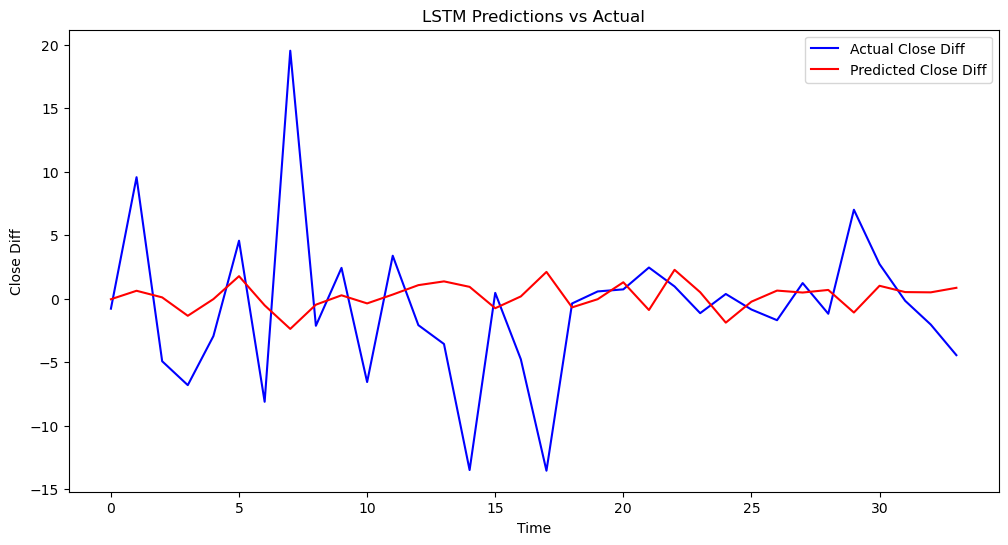

RMSE: 6.401553081709281
MSE: 40.97988185794159
MAE: 4.31596127853674


In [206]:



# Assuming ibm_data is your DataFrame and 'close_diff' is the target column
data = ibm_data['close_diff'].values

# Function to create sequences for LSTM
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Create sequences with a window size of 12
window_size = 10
X, y = create_sequences(data, window_size)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=30)

# Scaling the data with separate scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape input to be [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Building the LSTM model
model = Sequential()
model.add(LSTM(90, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
model.fit(X_train_scaled, y_train_scaled, validation_data=(X_test_scaled, y_test_scaled), epochs=20, batch_size=54, callbacks=[early_stopping])

# Making predictions
predictions_scaled = model.predict(X_test_scaled)

# Inverse transform predictions
predictions_inverse = scaler_y.inverse_transform(predictions_scaled)

# Inverse transform test labels
y_test_inverse = scaler_y.inverse_transform(y_test_scaled)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Close Diff', color='blue')
plt.plot(predictions_inverse, label='Predicted Close Diff', color='red')
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Close Diff')
plt.legend()
plt.show()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))

# Calculate MSE
mse = mean_squared_error(y_test_inverse, predictions_inverse)

# Calculate MAE
mae = mean_absolute_error(y_test_inverse, predictions_inverse)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")


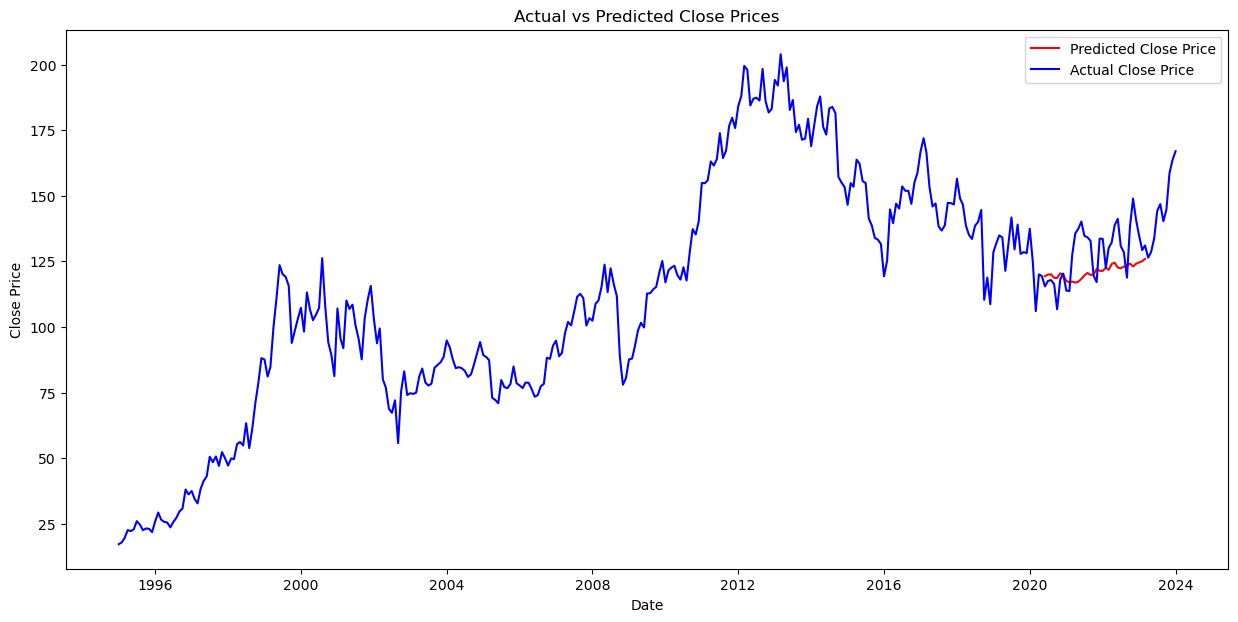

In [207]:
# Define the split_index
split_index = len(X_train)

# Calculate the last actual 'close' price from the training set
last_actual_close = ibm_data.iloc[split_index - 1]['close']

# Reconstruct the predicted 'close' prices by cumulatively summing the predicted 'close_diff'
predicted_close_prices = last_actual_close + np.cumsum(predictions_inverse.flatten())

# Plot the actual close prices and the predicted close prices
plt.figure(figsize=(15, 7))
plt.plot(ibm_data.index[split_index:split_index + len(predicted_close_prices)], predicted_close_prices, color='red', label='Predicted Close Price')
plt.plot(ibm_data.index, ibm_data['close'], color='blue', label='Actual Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


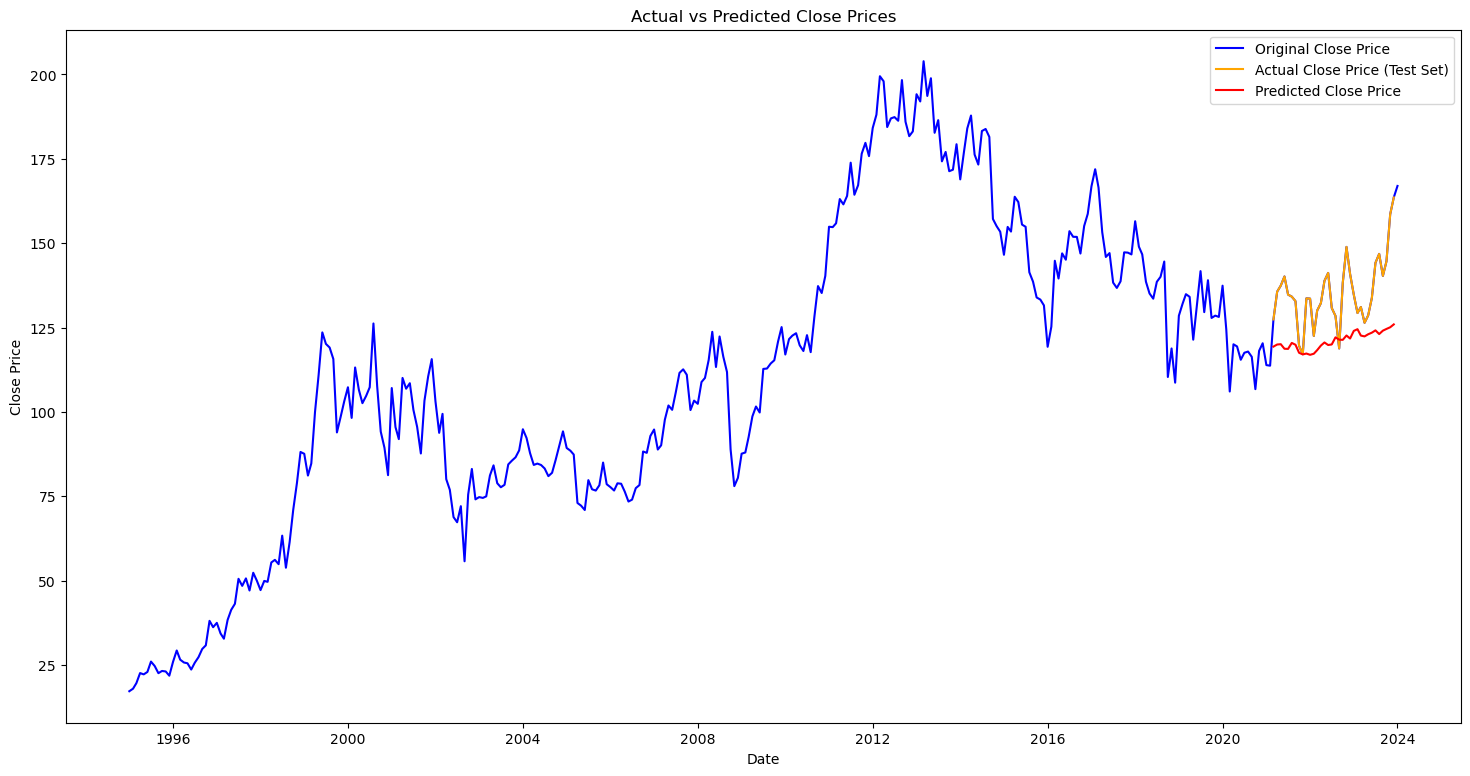

In [208]:


# Define the split_index
split_index = len(X_train)

# Assuming ibm_data contains the original 'close' column
# and the last value of the training data's 'close' column as the starting point
last_train_close = ibm_data.iloc[split_index - 1]['close']

# Reconstruct the predicted close prices
# Start with the last actual close price and add the cumulative sum of the predicted differences
reconstructed_predictions = last_train_close + np.cumsum(predictions_inverse.flatten())

# Extract the actual close prices corresponding to the test data
actual_close_prices = ibm_data['close'][split_index + window_size - 1: split_index + window_size - 1 + len(reconstructed_predictions)]

# Ensure that predicted_dates and reconstructed_predictions have the same length
predicted_dates = ibm_data.index[split_index + window_size - 1: split_index + window_size - 1 + len(reconstructed_predictions)]

# Plotting the original close data and the predicted close prices
plt.figure(figsize=(18, 9))
plt.plot(ibm_data.index, ibm_data['close'], color='blue', label='Original Close Price')
plt.plot(predicted_dates, actual_close_prices, color='orange', label='Actual Close Price (Test Set)')
plt.plot(predicted_dates, reconstructed_predictions, color='red', label='Predicted Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


## Forecast Horizons t+1 ,t+3 ,t+6

Epoch 1/100
9/9 [==============================] - 5s 120ms/step - loss: 0.1174 - val_loss: 0.0323
Epoch 2/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0383 - val_loss: 0.0234
Epoch 3/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0279 - val_loss: 0.0256
Epoch 4/100
9/9 [==============================] - 0s 25ms/step - loss: 0.0252 - val_loss: 0.0262
Epoch 5/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0242 - val_loss: 0.0238
Epoch 6/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0236 - val_loss: 0.0227
Epoch 7/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0228 - val_loss: 0.0243
Epoch 8/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0233 - val_loss: 0.0235
Epoch 9/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0231 - val_loss: 0.0227
Epoch 10/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0227 - val_loss: 0.0240
Epoch 11/100
9/9 [

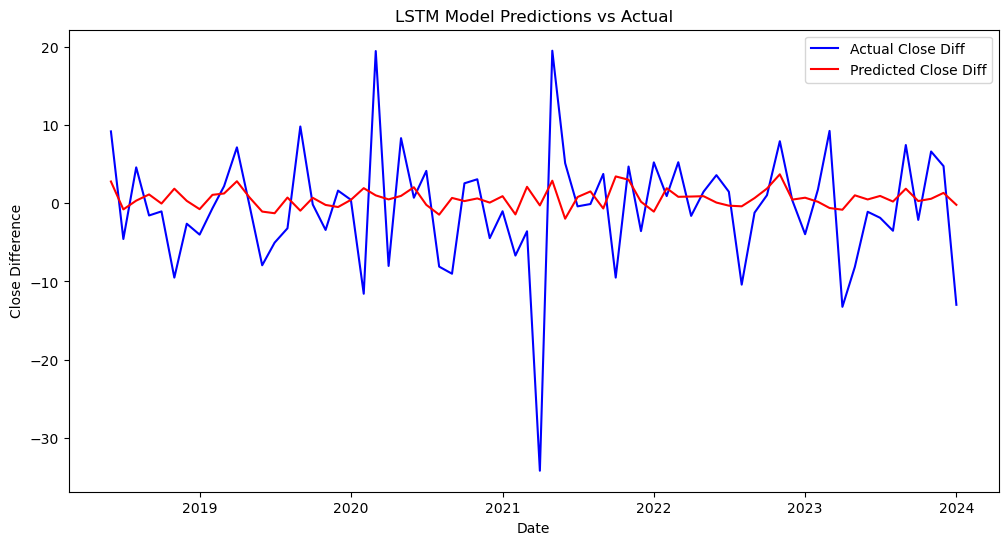

RMSE: 7.56472
MSE: 57.22504
MAE: 5.34752


In [214]:

# Differencing the 'close' column
ibm_data['close_diff'] = ibm_data['close'].diff().fillna(0)

# Create sequences
window_size = 12
X, y = create_sequences(ibm_data['close_diff'].values, window_size, 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape for LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], window_size, 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], window_size, 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# Make predictions
predictions = scaler_y.inverse_transform(model.predict(X_test_scaled))

# Calculate RMSE, MSE, MAE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(ibm_data.index[-len(y_test):], y_test, label='Actual Close Diff', color='blue')
plt.plot(ibm_data.index[-len(predictions):], predictions.flatten(), label='Predicted Close Diff', color='red')
plt.title('LSTM Model Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Difference')
plt.legend()
plt.show()

print(f'RMSE: {rmse:.5f}')
print(f'MSE: {mse:.5f}')
print(f'MAE: {mae:.5f}')


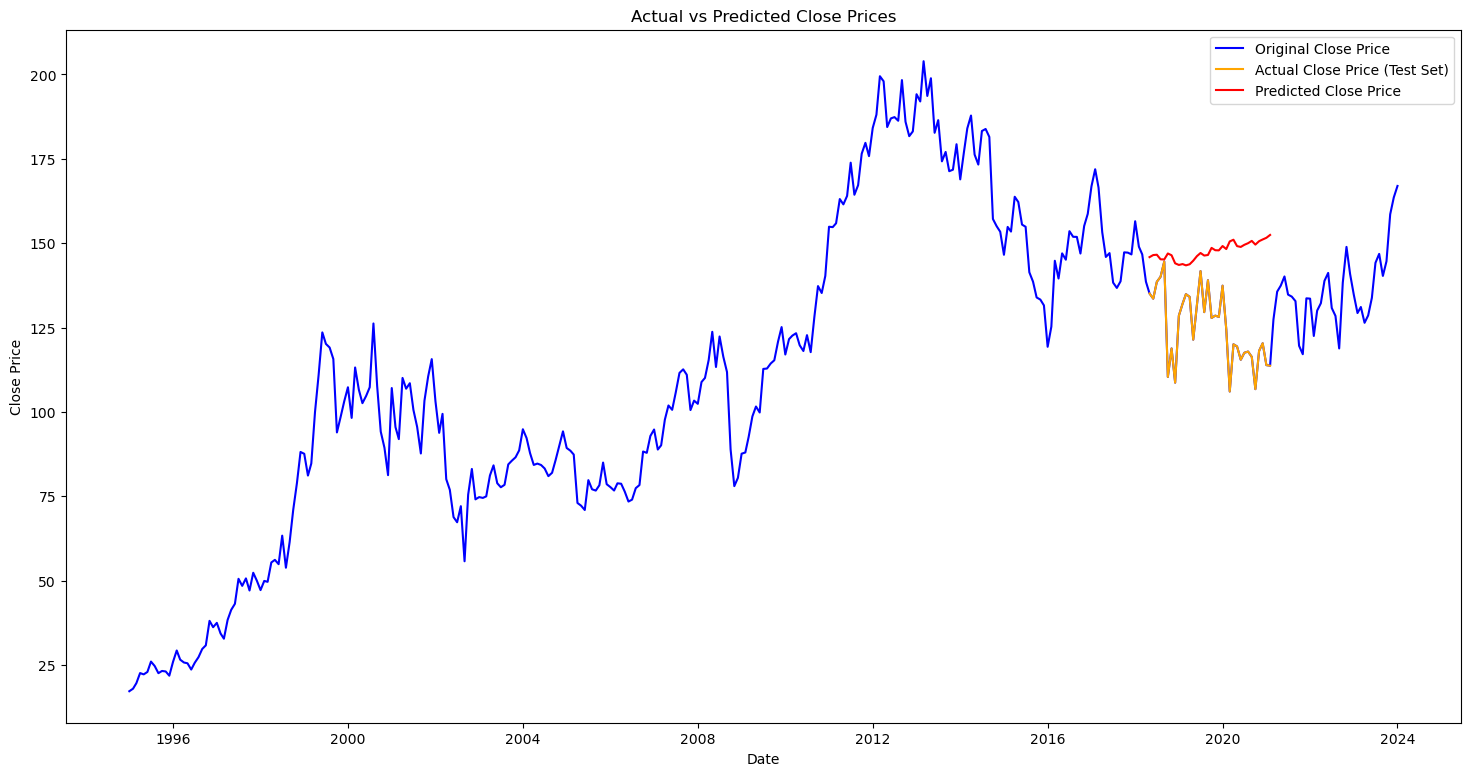

In [215]:
# Define the split_index
split_index = len(X_train)

# Assuming ibm_data contains the original 'close' column
# and the last value of the training data's 'close' column as the starting point
last_train_close = ibm_data.iloc[split_index - 1]['close']

# Reconstruct the predicted close prices
# Start with the last actual close price and add the cumulative sum of the predicted differences
reconstructed_predictions = last_train_close + np.cumsum(predictions_inverse.flatten())

# Extract the actual close prices corresponding to the test data
actual_close_prices = ibm_data['close'][split_index + window_size - 1: split_index + window_size - 1 + len(reconstructed_predictions)]

# Ensure that predicted_dates and reconstructed_predictions have the same length
predicted_dates = ibm_data.index[split_index + window_size - 1: split_index + window_size - 1 + len(reconstructed_predictions)]

# Plotting the original close data and the predicted close prices
plt.figure(figsize=(18, 9))
plt.plot(ibm_data.index, ibm_data['close'], color='blue', label='Original Close Price')
plt.plot(predicted_dates, actual_close_prices, color='orange', label='Actual Close Price (Test Set)')
plt.plot(predicted_dates, reconstructed_predictions, color='red', label='Predicted Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


## t+3

Epoch 1/100
9/9 [==============================] - 5s 140ms/step - loss: 0.1040 - val_loss: 0.0565
Epoch 2/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0404 - val_loss: 0.0271
Epoch 3/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0273 - val_loss: 0.0270
Epoch 4/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0249 - val_loss: 0.0305
Epoch 5/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0242 - val_loss: 0.0271
Epoch 6/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0242 - val_loss: 0.0277
Epoch 7/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0242 - val_loss: 0.0281
Epoch 8/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0242 - val_loss: 0.0277
Epoch 9/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0240 - val_loss: 0.0282
Epoch 10/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0243 - val_loss: 0.0276
Epoch 11/100
9/9 [

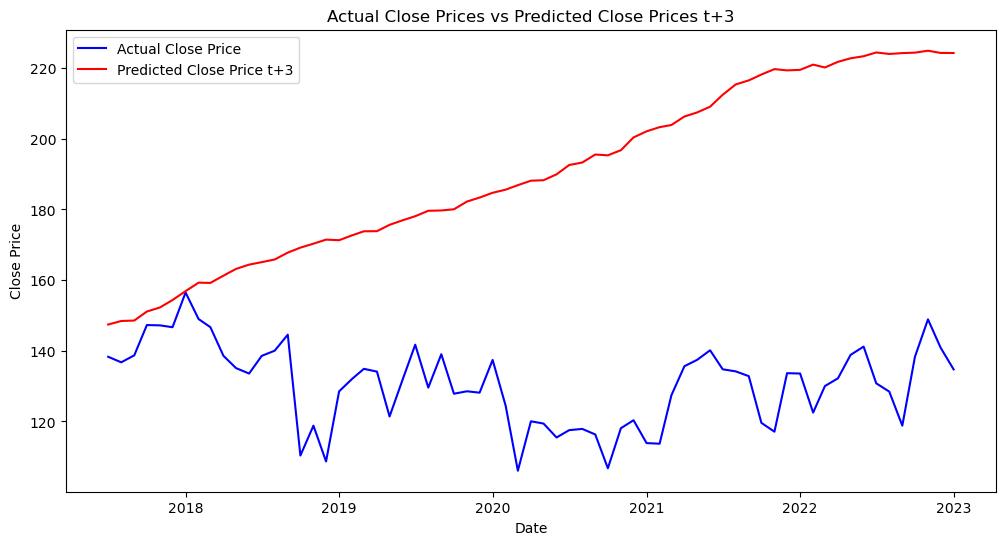

RMSE t+3: 8.452435085759785
MSE t+3: 71.44365887898303
MAE t+3: 5.960754663447168


In [115]:
# Update forecast horizon for t+3
forecast_horizon_t3 = 3
X_t3, y_t3 = create_sequences(data, window_size, forecast_horizon_t3)

# Splitting the data into train and test sets for t+3
X_train_t3, X_test_t3, y_train_t3, y_test_t3 = train_test_split(X_t3, y_t3, test_size=0.2, random_state=42)

# Scaling the data for t+3
X_train_t3_scaled = scaler_X.fit_transform(X_train_t3.reshape(-1, 1))
X_train_t3_scaled = X_train_t3_scaled.reshape((X_train_t3.shape[0], window_size, 1))
X_test_t3_scaled = scaler_X.transform(X_test_t3.reshape(-1, 1))
X_test_t3_scaled = X_test_t3_scaled.reshape((X_test_t3.shape[0], window_size, 1))

y_train_t3_scaled = scaler_y.fit_transform(y_train_t3.reshape(-1, 1))
y_test_t3_scaled = scaler_y.transform(y_test_t3.reshape(-1, 1))

# Building the LSTM model for t+3 forecasting
model_t3 = Sequential()
model_t3.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
model_t3.add(LSTM(50))
model_t3.add(Dense(1))

model_t3.compile(optimizer='adam', loss='mean_squared_error')

# Training the model with early stopping for t+3
early_stopping_t3 = EarlyStopping(monitor='val_loss', patience=10, mode='min')
model_t3.fit(X_train_t3_scaled, y_train_t3_scaled, epochs=100, batch_size=32, validation_data=(X_test_t3_scaled, y_test_t3_scaled), callbacks=[early_stopping_t3])

# Making predictions for t+3
predictions_scaled_t3 = model_t3.predict(X_test_t3_scaled)

# Inverse transforming the predictions for t+3
predictions_diff_t3 = scaler_y.inverse_transform(predictions_scaled_t3)

# Reverse the differencing to get the predicted 'close' prices for t+3
predicted_close_prices_t3 = [last_train_close + np.sum(predictions_diff_t3[:i]) for i in range(1, len(predictions_diff_t3) + 1)]

# Get the corresponding actual 'close' prices for the test set for t+3
actual_close_prices_t3 = ibm_data['close'][len(y_train_t3) + forecast_horizon_t3 - 1: len(y_train_t3) + len(predictions_diff_t3) + forecast_horizon_t3 - 1].values

# Plotting the results for t+3
plt.figure(figsize=(12, 6))
plt.plot(ibm_data.index[len(y_train_t3) + forecast_horizon_t3 - 1: len(y_train_t3) + len(predictions_diff_t3) + forecast_horizon_t3 - 1], actual_close_prices_t3, label='Actual Close Price', color='blue')
plt.plot(ibm_data.index[len(y_train_t3) + forecast_horizon_t3 - 1: len(y_train_t3) + len(predictions_diff_t3) + forecast_horizon_t3 - 1], predicted_close_prices_t3, label='Predicted Close Price t+3', color='red')
plt.title('Actual Close Prices vs Predicted Close Prices t+3')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#Ensure that the lengths of y_test_t3 and predictions_diff_t3 match
min_length_t3 = min(len(y_test_t3), len(predictions_diff_t3))

#Trim the longer array to match the length of the shorter one
y_test_t3_aligned = y_test_t3[:min_length_t3]
predictions_t3_aligned = predictions_diff_t3[:min_length_t3]

#Calculate evaluation metrics for t+3
rmse_t3 = np.sqrt(mean_squared_error(y_test_t3_aligned, predictions_t3_aligned))
mse_t3 = mean_squared_error(y_test_t3_aligned, predictions_t3_aligned)
mae_t3 = mean_absolute_error(y_test_t3_aligned, predictions_t3_aligned)

print(f'RMSE t+3: {rmse_t3}')
print(f'MSE t+3: {mse_t3}')
print(f'MAE t+3: {mae_t3}')


## t+6

Epoch 1/100
9/9 [==============================] - 5s 137ms/step - loss: 0.3109 - val_loss: 0.0258
Epoch 2/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0491 - val_loss: 0.0297
Epoch 3/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0260 - val_loss: 0.0334
Epoch 4/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0290 - val_loss: 0.0214
Epoch 5/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0229 - val_loss: 0.0213
Epoch 6/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0226 - val_loss: 0.0214
Epoch 7/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0224 - val_loss: 0.0208
Epoch 8/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0226 - val_loss: 0.0205
Epoch 9/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0221 - val_loss: 0.0209
Epoch 10/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0221 - val_loss: 0.0204
Epoch 11/100
9/9 [

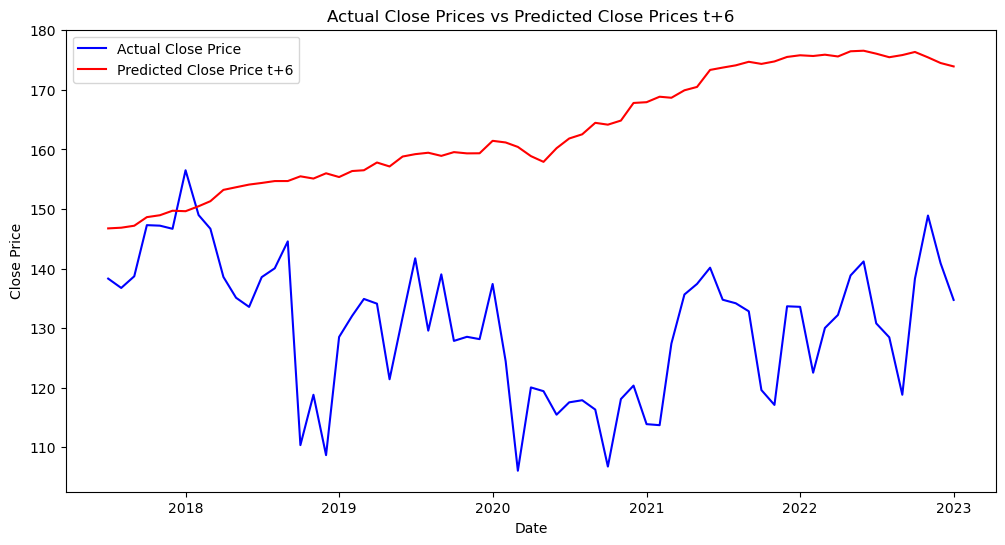

RMSE t+6: 7.677719068179569
MSE t+6: 58.94737008988816
MAE t+6: 5.742031194276607


In [116]:
# Assuming ibm_data, create_sequences, and other necessary functions and variables are already defined

# Update forecast horizon for t+6
forecast_horizon_t6 = 6
X_t6, y_t6 = create_sequences(data, window_size, forecast_horizon_t6)

# Splitting the data into train and test sets for t+6
X_train_t6, X_test_t6, y_train_t6, y_test_t6 = train_test_split(X_t6, y_t6, test_size=0.2, random_state=42)

# Scaling the data for t+6
X_train_t6_scaled = scaler_X.fit_transform(X_train_t6.reshape(-1, 1))
X_train_t6_scaled = X_train_t6_scaled.reshape((X_train_t6.shape[0], window_size, 1))
X_test_t6_scaled = scaler_X.transform(X_test_t6.reshape(-1, 1))
X_test_t6_scaled = X_test_t6_scaled.reshape((X_test_t6.shape[0], window_size, 1))

y_train_t6_scaled = scaler_y.fit_transform(y_train_t6.reshape(-1, 1))
y_test_t6_scaled = scaler_y.transform(y_test_t6.reshape(-1, 1))

# Building the LSTM model for t+6 forecasting
model_t6 = Sequential()
model_t6.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
model_t6.add(LSTM(50))
model_t6.add(Dense(1))

model_t6.compile(optimizer='adam', loss='mean_squared_error')

# Training the model with early stopping for t+6
early_stopping_t6 = EarlyStopping(monitor='val_loss', patience=10, mode='min')
model_t6.fit(X_train_t6_scaled, y_train_t6_scaled, epochs=100, batch_size=32, validation_data=(X_test_t6_scaled, y_test_t6_scaled), callbacks=[early_stopping_t6])

# Making predictions for t+6
predictions_scaled_t6 = model_t6.predict(X_test_t6_scaled)

# Inverse transforming the predictions for t+6
predictions_diff_t6 = scaler_y.inverse_transform(predictions_scaled_t6)

# Reverse the differencing to get the predicted 'close' prices for t+6
predicted_close_prices_t6 = [last_train_close + np.sum(predictions_diff_t6[:i]) for i in range(1, len(predictions_diff_t6) + 1)]

# Get the corresponding actual 'close' prices for the test set for t+6

actual_close_prices_t6 = ibm_data['close'][len(y_train_t6) + forecast_horizon_t6 - 1: len(y_train_t6) + len(predictions_diff_t6) + forecast_horizon_t6 - 1].values

#Plotting the results for t+6
plt.figure(figsize=(12, 6))
plt.plot(ibm_data.index[len(y_train_t6) + forecast_horizon_t6 - 1: len(y_train_t6) + len(predictions_diff_t6) + forecast_horizon_t6 - 1], actual_close_prices_t6, label='Actual Close Price', color='blue')
plt.plot(ibm_data.index[len(y_train_t6) + forecast_horizon_t6 - 1: len(y_train_t6) + len(predictions_diff_t6) + forecast_horizon_t6 - 1], predicted_close_prices_t6, label='Predicted Close Price t+6', color='red')
plt.title('Actual Close Prices vs Predicted Close Prices t+6')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#Ensure that the lengths of y_test_t6 and predictions_diff_t6 match
min_length_t6 = min(len(y_test_t6), len(predictions_diff_t6))

#Trim the longer array to match the length of the shorter one
y_test_t6_aligned = y_test_t6[:min_length_t6]
predictions_t6_aligned = predictions_diff_t6[:min_length_t6]

#Calculate evaluation metrics for t+6
rmse_t6 = np.sqrt(mean_squared_error(y_test_t6_aligned, predictions_t6_aligned))
mse_t6 = mean_squared_error(y_test_t6_aligned, predictions_t6_aligned)
mae_t6 = mean_absolute_error(y_test_t6_aligned, predictions_t6_aligned)

print(f'RMSE t+6: {rmse_t6}')
print(f'MSE t+6: {mse_t6}')
print(f'MAE t+6: {mae_t6}')

## Multivariate lstm model


### INDUSTRIAL PRODUCTION INDEX


C:\Users\DeLL\AppData\Local\Temp\ipykernel_16588\1698474600.py:34: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  merged_data.index = pd.to_datetime(merged_data.index, infer_datetime_format=True)


Epoch 1/100
12/12 [==============================] - 2s 3ms/step - loss: 0.3377
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 0.2608
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.1945
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1367
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0898
Epoch 6/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0547
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0318
Epoch 8/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 9/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 10/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 11/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 12/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 13/100
12/12 [=================

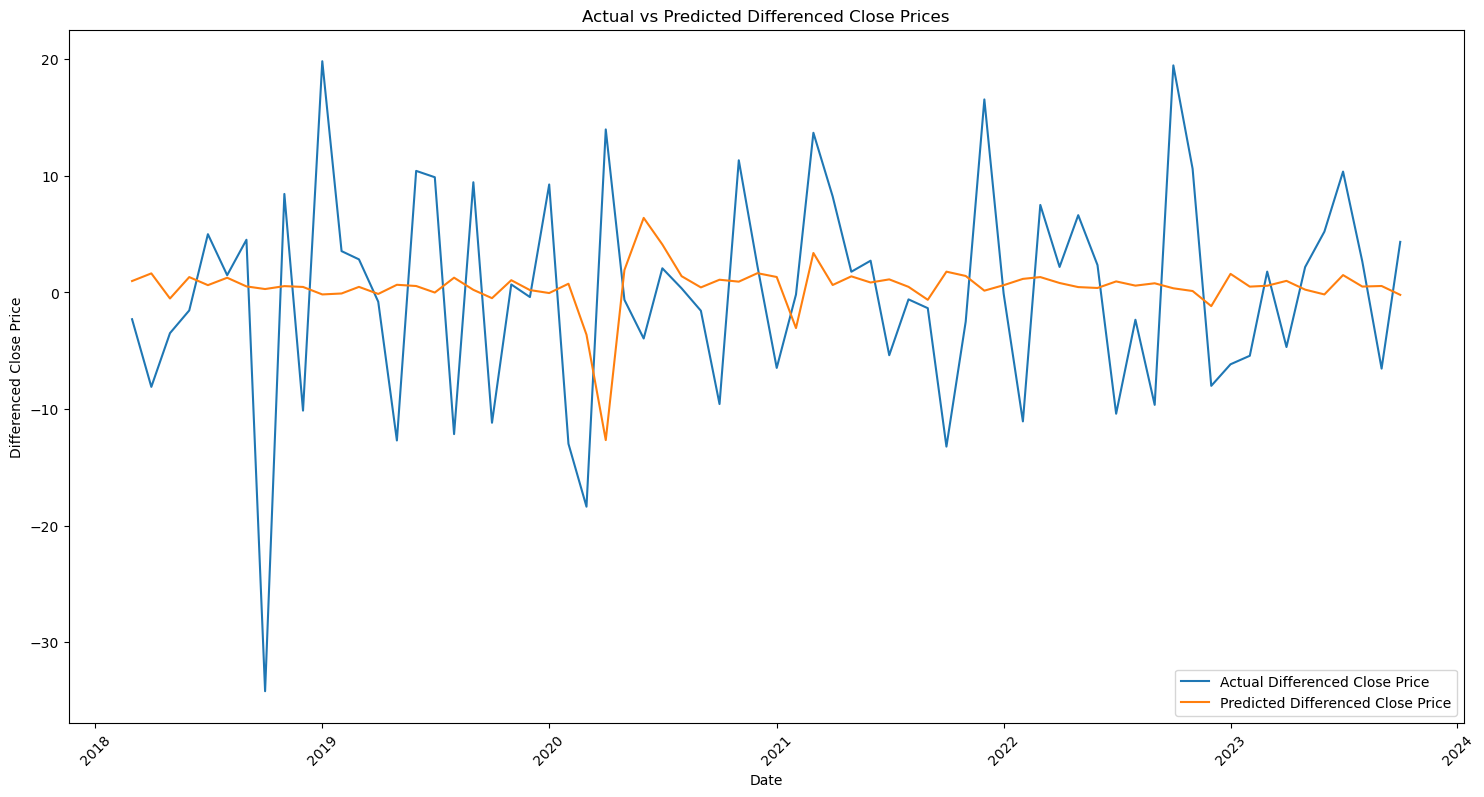

In [133]:
# Load the data
ipi_index = pd.read_csv('F:/data/Industrial production index.csv')
ibm_data = ibm_data

# Preprocess the Industrial Production Index
ipi_index['DATE'] = pd.to_datetime(ipi_index['DATE']).dt.to_period('M')
ipi_index.set_index('DATE', inplace=True)
ipi_index.index = ipi_index.index.to_timestamp()

# Filter out rows where the index (DATE) is on or after January 1995
ipi_index = ipi_index[ipi_index.index >= pd.to_datetime('1995-01-01')]

# Calculate the first difference for both datasets
ibm_data['close_diff'] = ibm_data['close'].diff()
ipi_index['IPI_diff'] = ipi_index['INDPRO'].diff()

# Drop the first row with NaN values after differencing
ibm_data = ibm_data.dropna()
ipi_index = ipi_index.dropna()

# Merge the dataframes on the DATE column
merged_data = pd.merge(ibm_data, ipi_index, left_index=True, right_index=True, how='inner')

#Convert the index to datetime, if it's not already
merged_data.index = pd.to_datetime(merged_data.index, infer_datetime_format=True)

#Select the differenced features and target
target = merged_data['close_diff'].values
features = merged_data[['IPI_diff']].values # Add other differenced features if available

#Initialize the scaler
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

#Scale the features and target
features_scaled = scaler_x.fit_transform(features)
target_scaled = scaler_y.fit_transform(target.reshape(-1, 1)).flatten()

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, shuffle=False)

#Reshape the data for LSTM layer
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

#Build the LSTM model
model = Sequential()
model.add(LSTM(units=60, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(X_train, y_train, epochs=100, batch_size=24, verbose=1)

#Predict and inverse transform to original scale
predictions_scaled = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions_scaled)

#Inverse transform y_test
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

#Calculate MSE and RMSE
mse = mean_squared_error(y_test_original, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:",mae)
#Extract the dates from merged_data for the test set for plotting
test_dates = merged_data.index[-len(predictions):]

#Plotting
plt.figure(figsize=(18, 9))
plt.plot(test_dates, y_test_original, label='Actual Differenced Close Price')
plt.plot(test_dates, predictions, label='Predicted Differenced Close Price')
plt.title('Actual vs Predicted Differenced Close Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.show()

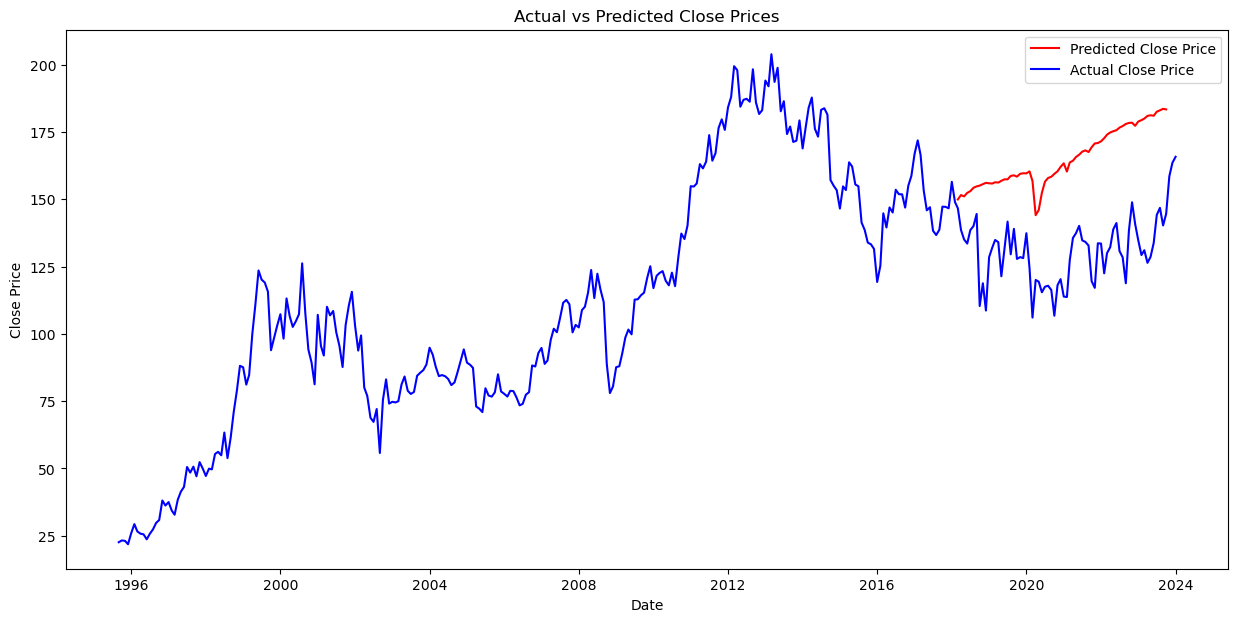

In [134]:
# Start with the last actual close price from the training set
last_train_close = ibm_data.iloc[len(X_train) - 1]['close']

# Reconstruct the predicted 'close' prices
# The predictions are the differenced values, so we need to add these to the last actual close price cumulatively
predicted_close_prices = [last_train_close]
for pred_diff in predictions.flatten():
    predicted_close_prices.append(predicted_close_prices[-1] + pred_diff)

# Remove the first element which was the last actual close price
predicted_close_prices.pop(0)

# Extract the test set dates
test_dates = merged_data.index[len(X_train):len(X_train) + len(predicted_close_prices)]

# Plotting the actual and predicted close prices
plt.figure(figsize=(15, 7))
plt.plot(test_dates, predicted_close_prices, color='red', label='Predicted Close Price')
plt.plot(ibm_data.index, ibm_data['close'], color='blue', label='Actual Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [ ]:
df_input.to_csv('C:/Users/DeLL/Documents/ibm_data and IPI index.csv', index=True)

### Non Farm  payroll employment

Epoch 1/100
20/20 [==============================] - 2s 3ms/step - loss: 0.3012
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.2015
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 0.1228
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0654
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0326
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0191
Epoch 7/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 8/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 9/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 10/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 11/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 12/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 13/100
20/20 [=================

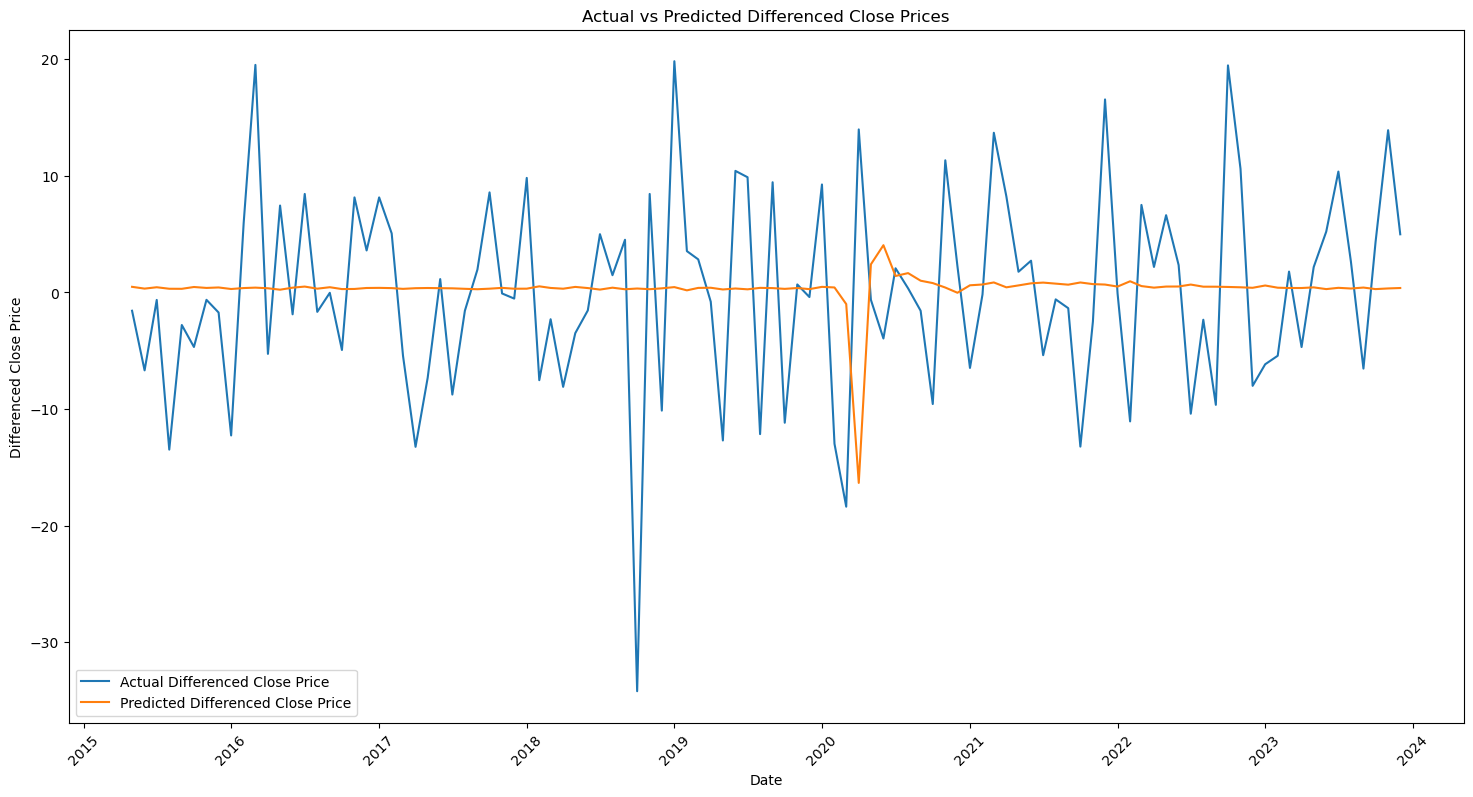

In [155]:

# Load the Non-Farm Payroll Employment data
payems = pd.read_csv('F:/data/Non_farm_payroll_employment.csv')

# Preprocess the Non-Farm Payroll Employment data
payems['DATE'] = pd.to_datetime(payems['DATE'])
payems['DATE'] = payems['DATE'].dt.strftime('%Y-%m')
payems.set_index('DATE', inplace=True)

# Ensure the index is in datetime format for comparison
payems.index = pd.to_datetime(payems.index, format='%Y-%m')  # Adjust the format as needed

# Filter out rows where the index (DATE) is on or after January 1995
payems = payems[payems.index >= pd.to_datetime('1995-01')]

# Calculate the first difference for the payems dataset
payems['PAYEMS_diff'] = payems['PAYEMS'].diff()

# Drop the first row with NaN values after differencing
payems = payems.dropna()

# Merge the differenced payems data with the ibm_data (assuming ibm_data has been first differenced)
merged_data = pd.merge(ibm_data, payems, left_index=True, right_index=True, how='inner')

# Select the differenced features and target
target = merged_data['close_diff'].values
features = merged_data[['PAYEMS_diff']].values  # Add other differenced features if available

#Initialize the scaler
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

#Scale the features and target
features_scaled = scaler_x.fit_transform(features)
target_scaled = scaler_y.fit_transform(target.reshape(-1, 1)).flatten()

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.31, shuffle=False)

#Reshape the data for LSTM layer
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

#Build the LSTM model
model = Sequential()
model.add(LSTM(units=30, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(X_train, y_train, epochs=100, batch_size=12, verbose=1)

#Predict and inverse transform to original scale
predictions_scaled = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions_scaled)

#Inverse transform y_test
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

#Calculate MSE and RMSE
mse = mean_squared_error(y_test_original, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)
print("Mean Absolute Error:",mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

#Extract the dates from merged_data for the test set for plotting
test_dates = merged_data.index[-len(predictions):]

#Plotting
plt.figure(figsize=(18, 9))
plt.plot(test_dates, y_test_original, label='Actual Differenced Close Price')
plt.plot(test_dates, predictions, label='Predicted Differenced Close Price')
plt.title('Actual vs Predicted Differenced Close Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

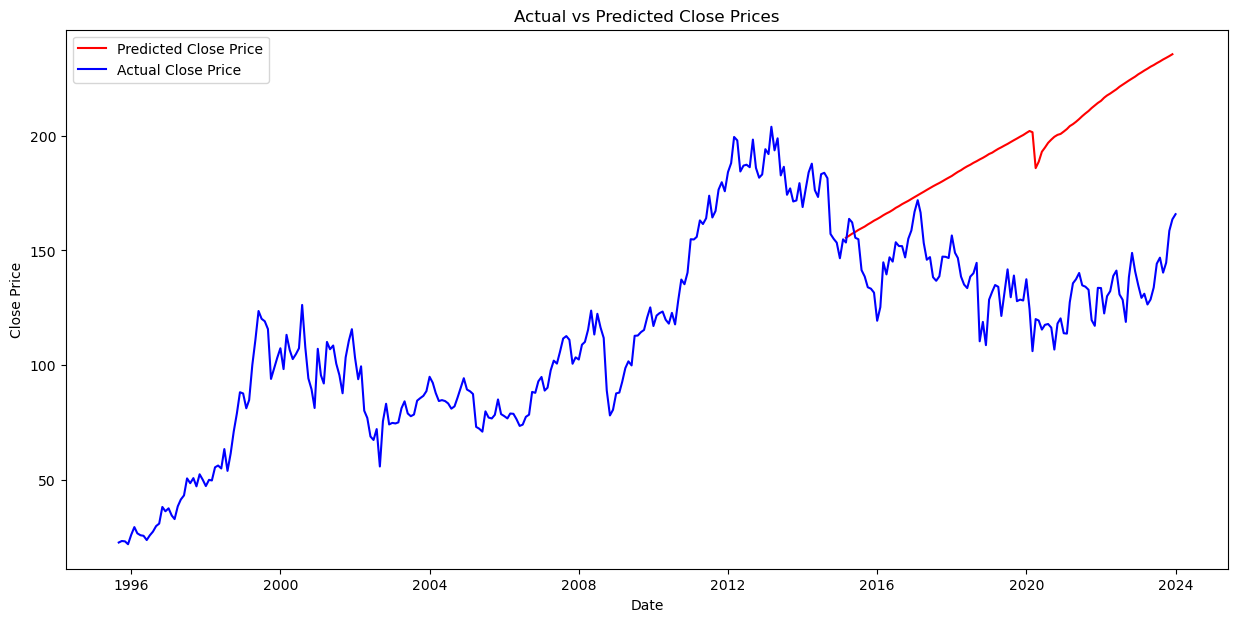

In [138]:

# Start with the last actual close price from the training set
last_train_close = ibm_data.iloc[len(X_train) - 1]['close']

# Reconstruct the predicted 'close' prices
# The predictions are the differenced values, so we need to add these to the last actual close price cumulatively
predicted_close_prices = [last_train_close]
for pred_diff in predictions.flatten():
    predicted_close_prices.append(predicted_close_prices[-1] + pred_diff)

# Remove the first element which was the last actual close price
predicted_close_prices.pop(0)

# Extract the test set dates
test_dates = merged_data.index[len(X_train):len(X_train) + len(predicted_close_prices)]

# Plotting the actual and predicted close prices
plt.figure(figsize=(15, 7))
plt.plot(test_dates, predicted_close_prices, color='red', label='Predicted Close Price')
plt.plot(ibm_data.index, ibm_data['close'], color='blue', label='Actual Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [ ]:
df_input.to_csv('C:/Users/DeLL/Documents/ibm_data and Non Farm payroll employment.csv', index=True)

### real manufacturing and trade sales

Epoch 1/100
19/19 [==============================] - 2s 3ms/step - loss: 0.2917
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 0.1923
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 0.1133
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0561
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0263
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 7/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 8/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 9/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0154
Epoch 10/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 11/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 12/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 13/100
19/19 [=================

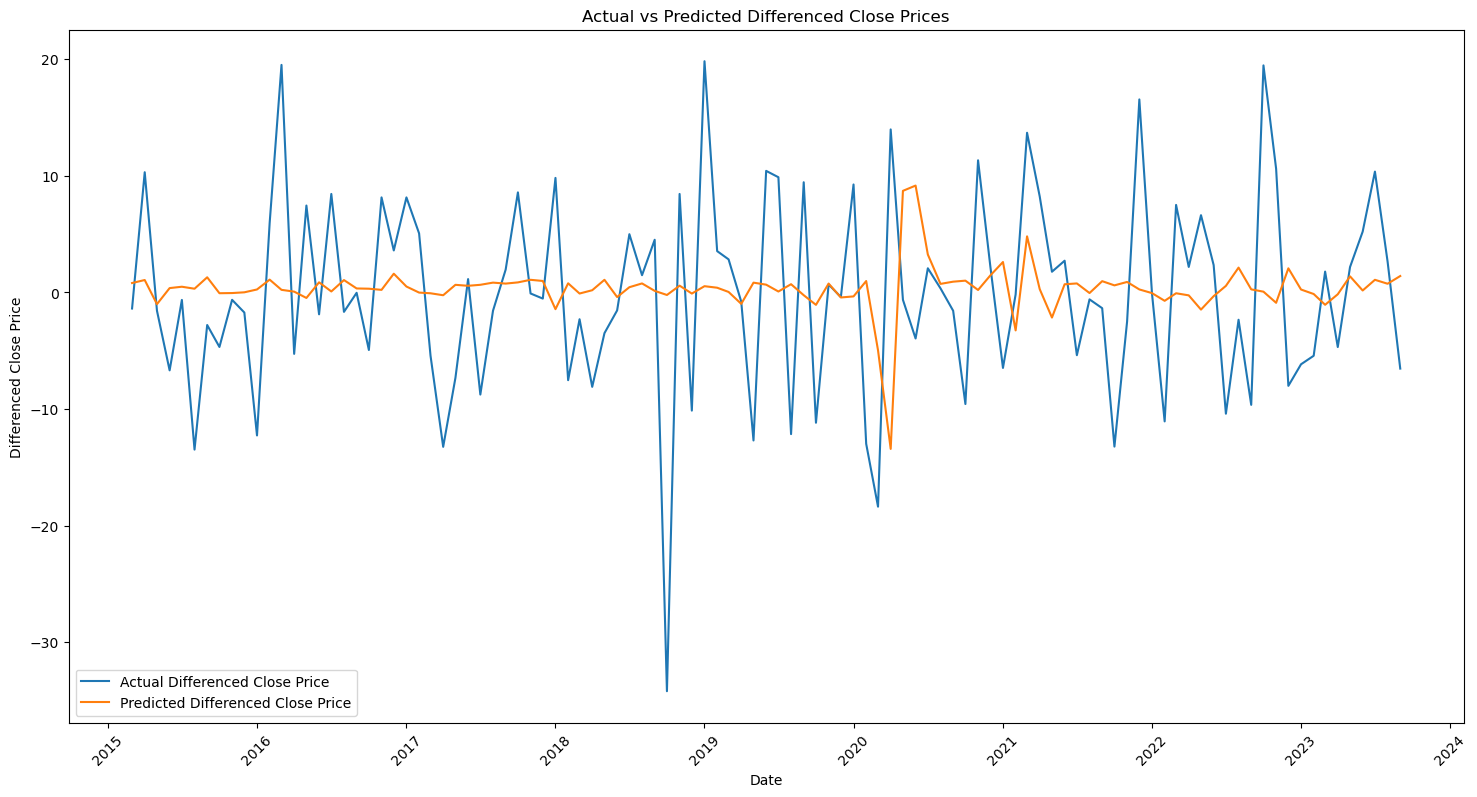

In [156]:

# Load the Real manufacturing and trade sales data
rmats = pd.read_csv('F:/data/Real manufacturing and trade sales.csv')

# Preprocess the dataset
rmats['DATE'] = pd.to_datetime(rmats['DATE'])
rmats.set_index('DATE', inplace=True)

# Filter out rows where the index (DATE) is on or after January 1995
rmats = rmats[rmats.index >= pd.to_datetime('1995-01')]

# Assuming ibm_data is your main dataset which contains 'close' prices
# Calculate the first difference for both datasets to make them stationary
ibm_data['close_diff'] = ibm_data['close'].diff()
rmats['RMATS_diff'] = rmats['CMRMTSPL'].diff()  # Replace 'RMATS' with the actual column name in rmats dataset

# Drop the first row with NaN values after differencing
ibm_data = ibm_data.dropna()
rmats = rmats.dropna()

# Merge the dataframes on the DATE column
merged_data = pd.merge(ibm_data, rmats, left_index=True, right_index=True, how='inner')

# Select the differenced features and target
target = merged_data['close_diff'].values
features = merged_data[['RMATS_diff']].values  # Add other differenced features if available

# Initialize the scaler
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Scale the features and target
features_scaled = scaler_x.fit_transform(features)
target_scaled = scaler_y.fit_transform(target.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled
, target_scaled, test_size=0.31, shuffle=False)

#Reshape the data for LSTM layer
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

#Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(X_train, y_train, epochs=100, batch_size=12, verbose=1)

#Predict and inverse transform to original scale
predictions_scaled = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions_scaled)

#Inverse transform y_test
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

#Calculate MSE and RMSE
mse = mean_squared_error(y_test_original, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)
print("Mean Absolute Error:",mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

#Extract the dates from merged_data for the test set for plotting
test_dates = merged_data.index[-len(predictions):]

#Plotting
plt.figure(figsize=(18, 9))
plt.plot(test_dates, y_test_original, label='Actual Differenced Close Price')
plt.plot(test_dates, predictions, label='Predicted Differenced Close Price')
plt.title('Actual vs Predicted Differenced Close Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.show()

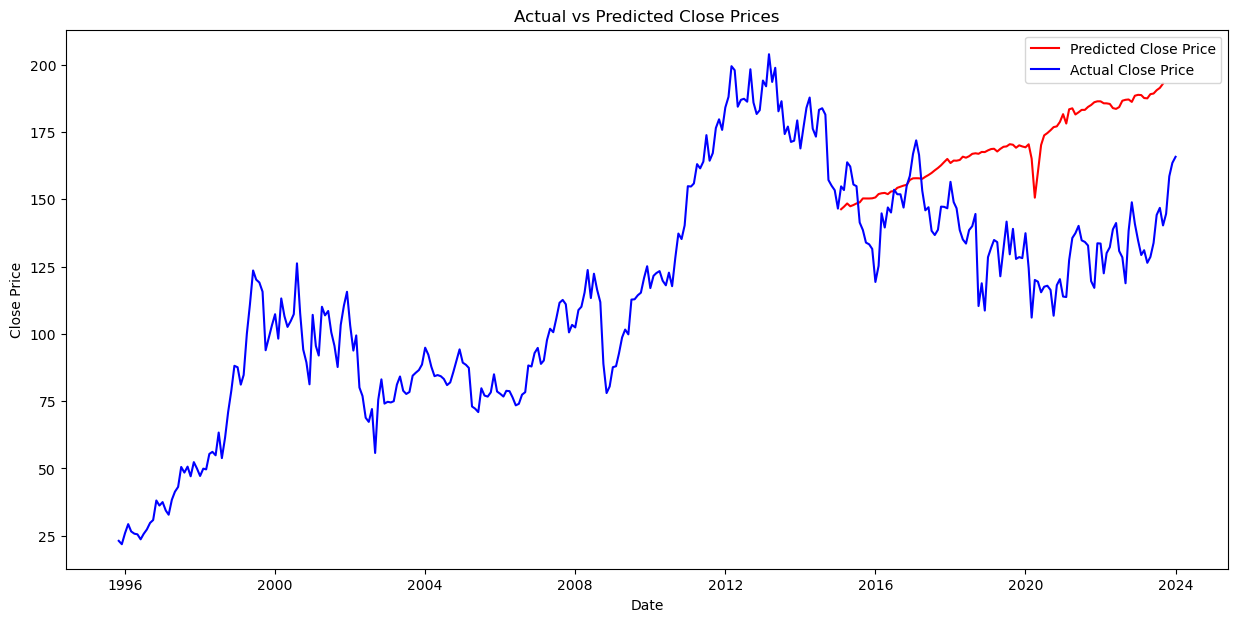

In [141]:

# Start with the last actual close price from the training set
last_train_close = ibm_data.iloc[len(X_train) - 1]['close']

# Reconstruct the predicted 'close' prices
# The predictions are the differenced values, so we need to add these to the last actual close price cumulatively
predicted_close_prices = [last_train_close]
for pred_diff in predictions.flatten():
    predicted_close_prices.append(predicted_close_prices[-1] + pred_diff)

# Remove the first element which was the last actual close price
predicted_close_prices.pop(0)

# Extract the test set dates
test_dates = merged_data.index[len(X_train):len(X_train) + len(predicted_close_prices)]

# Plotting the actual and predicted close prices
plt.figure(figsize=(15, 7))
plt.plot(test_dates, predicted_close_prices, color='red', label='Predicted Close Price')
plt.plot(ibm_data.index, ibm_data['close'], color='blue', label='Actual Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [ ]:
df_input.to_csv('C:/Users/DeLL/Documents/ibm_data and real manufacturing and trade sales.csv', index=True)

### Real personal income excluding transfer receipt

Epoch 1/100
19/19 [==============================] - 2s 3ms/step - loss: 0.2810
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1848
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1074
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0530
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0250
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 10/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 11/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 12/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 13/100
19/19 [=================

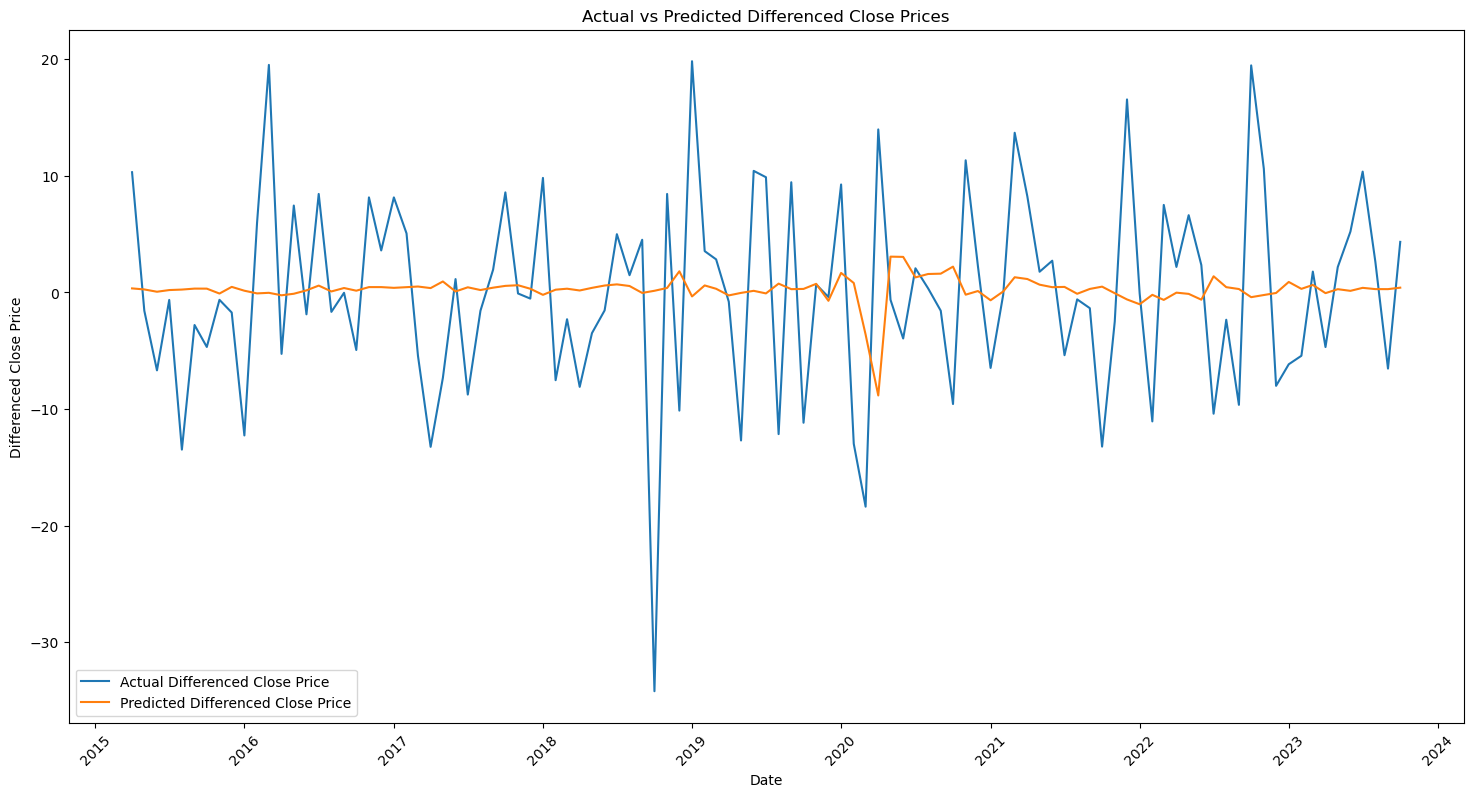

In [158]:

# Load the Real manufacturing and trade sales data
rpietr = pd.read_csv('F:/data/Real personal income excluding transfer receipt.csv')

# Preprocess the dataset
rpietr['DATE'] = pd.to_datetime(rpietr['DATE'])
rpietr.set_index('DATE', inplace=True)

# Filter out rows where the index (DATE) is on or after January 1995
rpietr = rpietr[rpietr.index >= pd.to_datetime('1995-01')]

# Assuming ibm_data is your main dataset which contains 'close' prices
# Calculate the first difference for both datasets to make them stationary
ibm_data['close_diff'] = ibm_data['close'].diff()
rpietr['rpietr_diff'] = rpietr['W875RX1'].diff()  # Replace 'RMATS' with the actual column name in rmats dataset

# Drop the first row with NaN values after differencing
ibm_data = ibm_data.dropna()
rpietr = rpietr.dropna()

# Merge the dataframes on the DATE column
merged_data = pd.merge(ibm_data, rpietr, left_index=True, right_index=True, how='inner')

# Select the differenced features and target
target = merged_data['close_diff'].values
features = merged_data[['rpietr_diff']].values  # Add other differenced features if available

# Initialize the scaler
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Scale the features and target
features_scaled = scaler_x.fit_transform(features)
target_scaled = scaler_y.fit_transform(target.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled
, target_scaled, test_size=0.31, shuffle=False)

#Reshape the data for LSTM layer
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

#Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(X_train, y_train, epochs=100, batch_size=12, verbose=1)

#Predict and inverse transform to original scale
predictions_scaled = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions_scaled)

#Inverse transform y_test
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

#Calculate MSE and RMSE
mse = mean_squared_error(y_test_original, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)
print("Mean Absolute Error:",mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

#Extract the dates from merged_data for the test set for plotting
test_dates = merged_data.index[-len(predictions):]

#Plotting
plt.figure(figsize=(18, 9))
plt.plot(test_dates, y_test_original, label='Actual Differenced Close Price')
plt.plot(test_dates, predictions, label='Predicted Differenced Close Price')
plt.title('Actual vs Predicted Differenced Close Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.show()

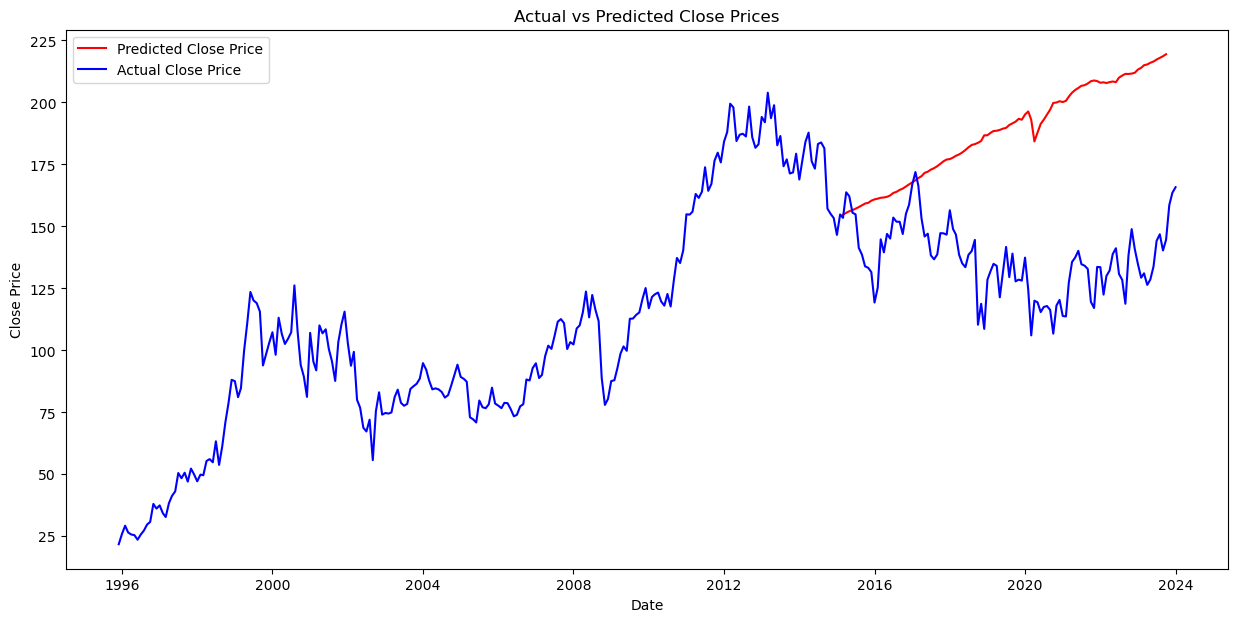

In [148]:

# Start with the last actual close price from the training set
last_train_close = ibm_data.iloc[len(X_train) - 1]['close']

# Reconstruct the predicted 'close' prices
# The predictions are the differenced values, so we need to add these to the last actual close price cumulatively
predicted_close_prices = [last_train_close]
for pred_diff in predictions.flatten():
    predicted_close_prices.append(predicted_close_prices[-1] + pred_diff)

# Remove the first element which was the last actual close price
predicted_close_prices.pop(0)

# Extract the test set dates
test_dates = merged_data.index[len(X_train):len(X_train) + len(predicted_close_prices)]

# Plotting the actual and predicted close prices
plt.figure(figsize=(15, 7))
plt.plot(test_dates, predicted_close_prices, color='red', label='Predicted Close Price')
plt.plot(ibm_data.index, ibm_data['close'], color='blue', label='Actual Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


### All four features


Epoch 1/100
19/19 [==============================] - 2s 3ms/step - loss: 0.3790
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1674
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0534
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0184
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 10/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 11/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 12/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 13/100
19/19 [=================

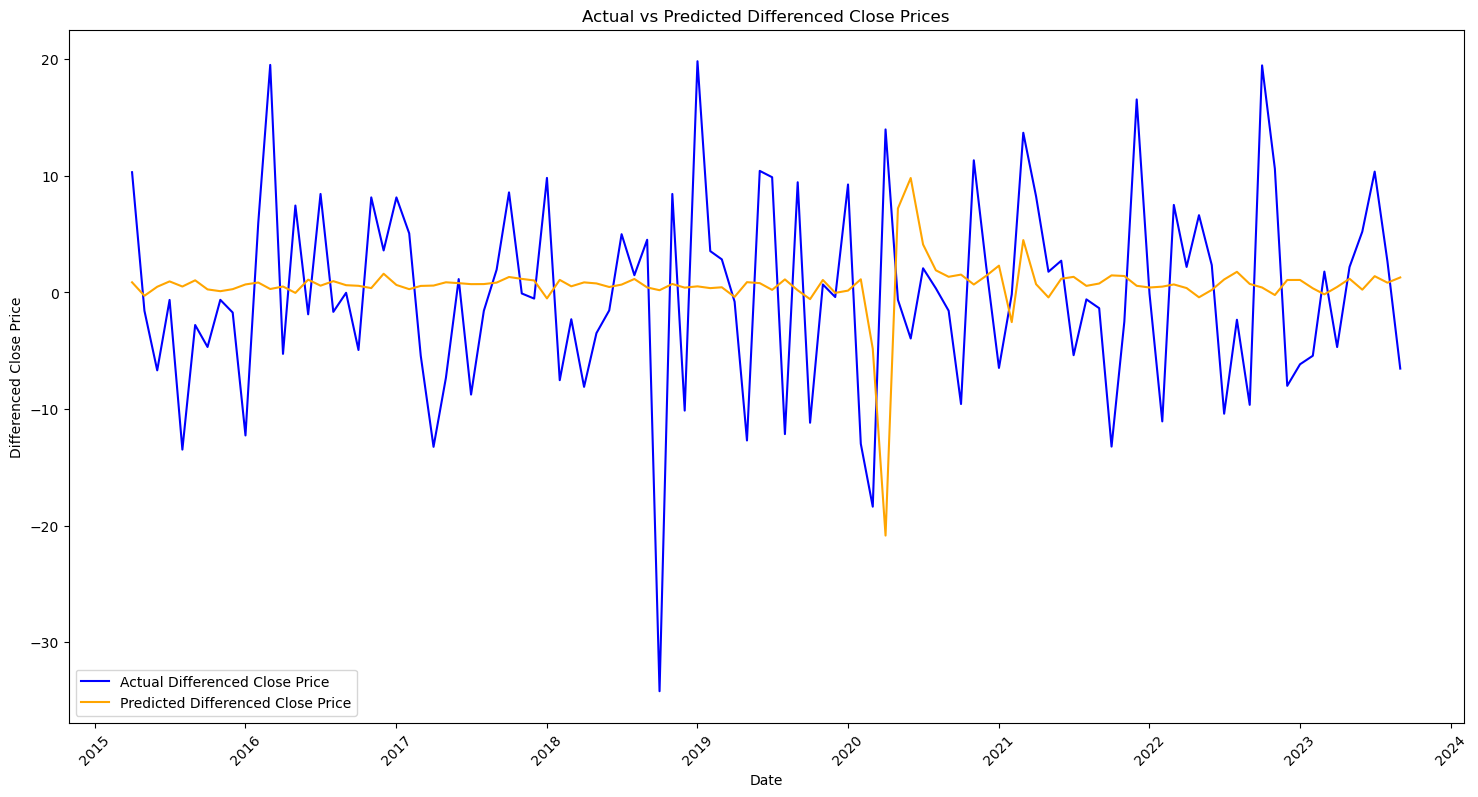

In [159]:

# Assuming all dataframes (rpietr, rmats, payems, ipi_index, ibm_data) are already loaded and have 'DATE' as index

# Calculate the first difference to make the series stationary
rpietr['RPIETR_diff'] = rpietr['W875RX1'].diff()
rmats['RMATS_diff'] = rmats['CMRMTSPL'].diff()
payems['PAYEMS_diff'] = payems['PAYEMS'].diff()
ipi_index['INDPRO_diff'] = ipi_index['INDPRO'].diff()
ibm_data['close_diff'] = ibm_data['close'].diff()

# Interpolate missing values
rpietr.interpolate(method='linear', inplace=True)
rmats.interpolate(method='linear', inplace=True)
payems.interpolate(method='linear', inplace=True)
ipi_index.interpolate(method='linear', inplace=True)
ibm_data.interpolate(method='linear', inplace=True)

# Drop any remaining NaNs after interpolation
rpietr.dropna(inplace=True)
rmats.dropna(inplace=True)
payems.dropna(inplace=True)
ipi_index.dropna(inplace=True)
ibm_data.dropna(inplace=True)

# Merge the dataframes on their index (DATE)
merged_data = pd.concat([rpietr, rmats, payems, ipi_index, ibm_data], axis=1, join='inner')

# Select features and target
features = merged_data[['RPIETR_diff', 'RMATS_diff', 'PAYEMS_diff', 'INDPRO_diff']].values
target = merged_data['close_diff'].values

# Initialize the scalers
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Scale the features and target
features_scaled = scaler_x.fit_transform(features)
target_scaled = scaler_y.fit_transform(target.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.31, shuffle=False)

# Reshape the data for LSTM layer
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=12, verbose=1)

# Predict and inverse transform to original scale
predictions_scaled = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions_scaled)

#Inverse transform y_test to original scale
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

#Calculate MSE and RMSE
mse = mean_squared_error(y_test_original, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)
print("Mean Absolute Error:",mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

#Plotting
plt.figure(figsize=(18, 9))
test_dates = merged_data.index[-len(predictions):] # Assuming the dates are aligned
plt.plot(test_dates, y_test_original, label='Actual Differenced Close Price', color='blue')
plt.plot(test_dates, predictions.flatten(), label='Predicted Differenced Close Price', color='orange')
plt.title('Actual vs Predicted Differenced Close Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.show()

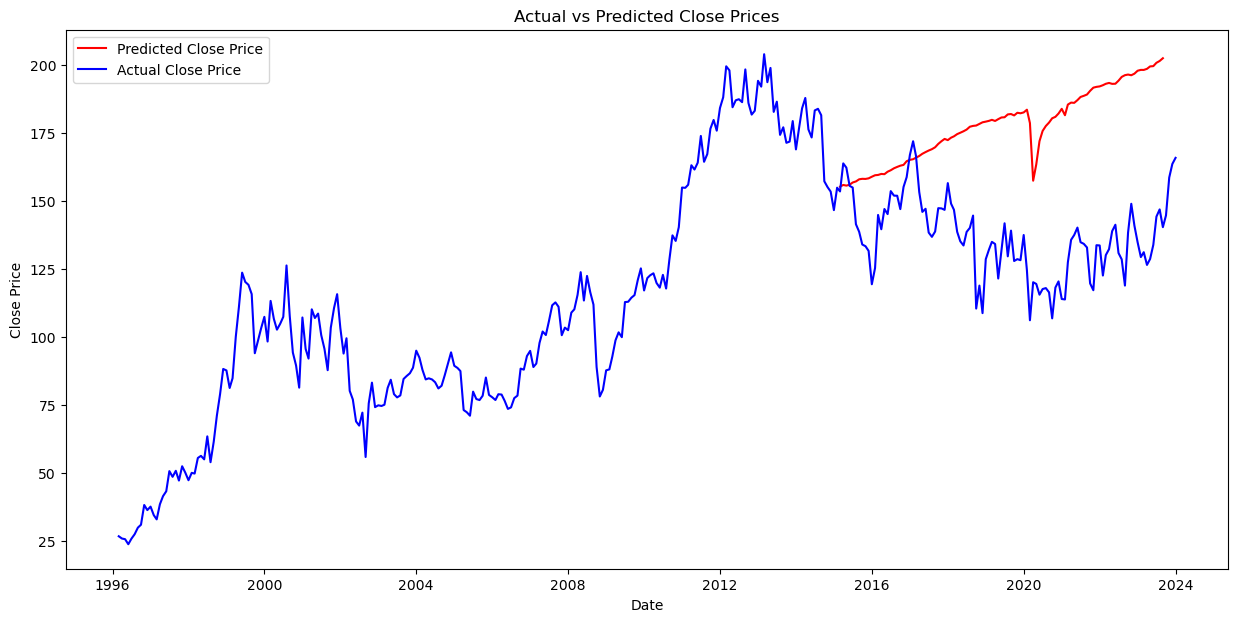

In [154]:
# Start with the last actual close price from the training set
last_train_close = ibm_data.iloc[len(X_train) - 1]['close']

# Reconstruct the predicted 'close' prices
# The predictions are the differenced values, so we need to add these to the last actual close price cumulatively
predicted_close_prices = [last_train_close]
for pred_diff in predictions.flatten():
    predicted_close_prices.append(predicted_close_prices[-1] + pred_diff)

# Remove the first element which was the last actual close price
predicted_close_prices.pop(0)

# Extract the test set dates
test_dates = merged_data.index[len(X_train):len(X_train) + len(predicted_close_prices)]

# Plotting the actual and predicted close prices
plt.figure(figsize=(15, 7))
plt.plot(test_dates, predicted_close_prices, color='red', label='Predicted Close Price')
plt.plot(ibm_data.index, ibm_data['close'], color='blue', label='Actual Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [ ]:
df_input.to_csv('C:/Users/DeLL/Documents/ibm_data and All three features.csv', index=True)

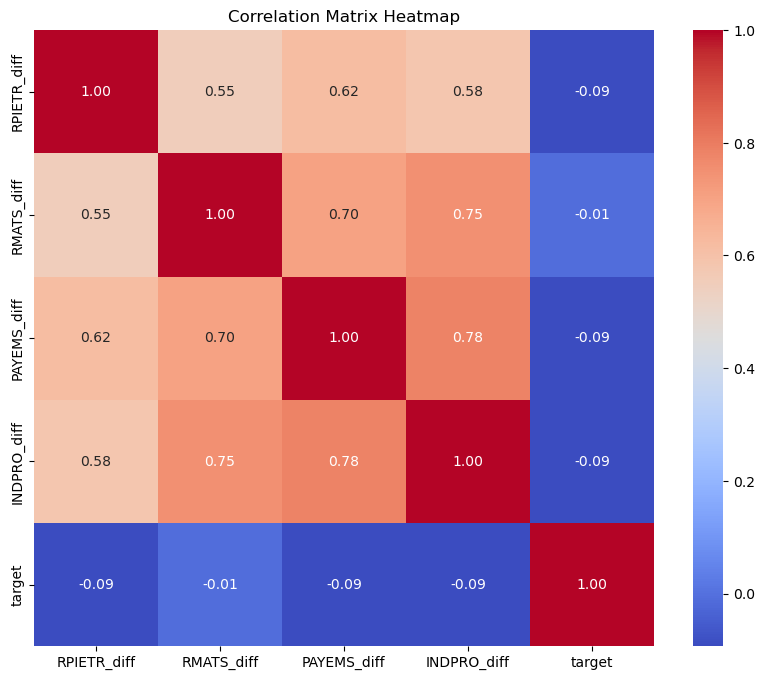

In [216]:

# Assuming rpietr, rmats, payems, ipi_index, and ibm_data are already loaded DataFrames
# and they all have 'DATE' as their index.

# Merge the dataframes on their index (DATE)
merged_data = pd.concat([rpietr, rmats, payems, ipi_index, ibm_data], axis=1, join='inner')

# Select features and target
features = merged_data[['RPIETR_diff', 'RMATS_diff', 'PAYEMS_diff', 'INDPRO_diff']]
target = merged_data['close_diff']

# Create a new DataFrame for the correlation matrix
correlation_data = features.copy()
correlation_data['target'] = target

# Calculate the correlation matrix
corr_matrix = correlation_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()
